 # Housing Prices Competition

**Project Goal**  
The objective of this project is to develop a machine learning model that predicts house sale prices based on various property attributes.

---

**Overview**  
The dataset consists of the following files:

- **Training Set (`train.csv`)**:  
  This dataset is used to train machine learning models. It includes various house features and their corresponding sale prices (`SalePrice`). The model will learn relationships between property attributes and sale price.

- **Test Set (`test.csv`)**:  
  This dataset is used for making predictions on unseen data. It contains the same features as the training set but does **not** include the sale price. The task is to predict `SalePrice` for each house in the test set.

- **Data Dictionary (`data_description.txt`)**:  
  A detailed explanation of each feature present in the dataset.

---

**Evaluation Metric**  
The competition evaluates submissions using **Root Mean Squared Error (RMSE)** between the logarithm of the predicted and actual sale prices. This transformation ensures that errors in predicting expensive houses and cheaper houses are weighted equally.

---

**Data Dictionary**  
A brief description of key variables in the dataset:

| **Feature**       | **Description**                                       |
|------------------|---------------------------------------------------|
| `SalePrice`      | The property's sale price (target variable)       |
| `MSSubClass`     | Type of dwelling involved in the sale             |
| `MSZoning`       | General zoning classification                     |
| `LotFrontage`    | Linear feet of street connected to property       |
| `LotArea`        | Lot size in square feet                           |
| `Street`         | Type of road access                               |
| `Neighborhood`   | Location within Ames city limits                  |
| `OverallQual`    | Overall material and finish quality               |
| `OverallCond`    | Overall condition rating                          |
| `YearBuilt`      | Original construction date                        |
| `YearRemodAdd`   | Remodel date                                      |
| `GrLivArea`      | Above grade (ground) living area in square feet   |
| `GarageCars`     | Size of garage in car capacity                    |
| `GarageArea`     | Garage size in square feet                        |
| `TotalBsmtSF`    | Total square feet of basement area                |
| `FullBath`       | Full bathrooms above grade                        |
| `HalfBath`       | Half bathrooms above grade                        |
| `Bedroom`        | Number of bedrooms above basement level           |
| `KitchenQual`    | Kitchen quality                                   |
| `Fireplaces`     | Number of fireplaces                              |
| `SaleType`       | Type of sale                                      |
| `SaleCondition`  | Condition of sale                                 |

A full description of all features is available in `data_description.txt`.

---

**Project Execution Plan**  

**1. Data Loading & Initial Inspection**  
- Load the dataset (`train.csv`, `test.csv`).
- Explore dataset structure, check feature types, and inspect a few samples.
- Identify missing values, inconsistencies, or formatting issues.

**2. Data Preprocessing**  
- Handle missing values using appropriate strategies (e.g., median imputation, categorical encoding).
- Convert categorical variables into numerical representations.
- Normalize or standardize numerical features if required.

**3. Exploratory Data Analysis (EDA)**  
- Visualize distributions of numerical and categorical features.
- Identify outliers and anomalies.
- Analyze correlations between features and `SalePrice`.
- Perform feature selection to retain only the most important predictors.

**4. Model Training & Hyperparameter Tuning**  
- Split data into training and validation sets.
- Train multiple machine learning models:
  - Linear Regression
  - Ridge Regression
  - Lasso Regression
  - Random Forest
  - Gradient Boosting (XGBoost, LightGBM, CatBoost)
- Perform hyperparameter tuning using cross-validation.
- Compare models based on RMSE performance.

**8. Conclusion & Documentation**  
- Summarize findings from the analysis and model training process.
- Justify model selection and performance comparisons.
- Provide insights on how property features affect house prices.
---



# Data loading

In [13]:
# Standard libraries
import time, warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Additional libraries
import phik
import shap

# Sklearn imports
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer

# XGBoost import
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Constants
RANDOM_STATE = 42

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [14]:
# Load datasets
path = '/home/nickolas/data_science/housing/source'
train_path = os.path.join(path, 'train.csv')
test_path = os.path.join(path, 'test.csv')

if os.path.exists(train_path) and os.path.exists(test_path):
    train = pd.read_csv(train_path, delimiter=',')
    test = pd.read_csv(test_path, delimiter=',')
    
    print("train.csv:")
    display(train.head())
    train.info()

    print("\ntest.csv:")
    display(test.head())
    test.info()
else:
    print("Directory or files not found")

train.csv:


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
4         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   
2       Norm     1Fam     2Story            5            5       1997   
3       Norm     1Fam     2Story            6            6       1998   
4       Norm   TwnhsE     1Story            8            5       1992   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd        NaN   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2          1998     Gable  CompShg     VinylSd     VinylSd        NaN   
3          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4          1992     Gable  CompShg     HdBoard     HdBoard        NaN   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   
2         0.0        TA        TA      PConc       Gd       TA           No   
3        20.0        TA        TA      PConc       TA       TA           No   
4         0.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   
2          GLQ       791.0          Unf         0.0      137.0        928.0   
3          GLQ       602.0          Unf         0.0      324.0        926.0   
4          ALQ       263.0          Unf         0.0     1017.0       1280.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        TA          Y      SBrkr       896         0             0   
1    GasA        TA          Y      SBrkr      1329         0             0   
2    GasA        Gd          Y      SBrkr       928       701             0   
3    GasA        Ex          Y      SBrkr       926       678             0   
4    GasA        Ex          Y      SBrkr      1280         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        896           0.0           0.0         1         0             2   
1       1329           0.0           0.0         1         1             3   
2       1629           0.0           0.0         2         1             3   
3       1604           0.0           0.0         2         1             3   
4       1280           0.0           0.0         2         0             2   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          TA             5        Typ           0         NaN   
1             1          Gd             6        Typ           0         NaN   
2             1          TA             6        Typ           1          TA   
3             1          Gd  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

**Dataset Summary - `train.csv` and `test.csv`**  

**Training Set (`train.csv`):**  
- **Total Entries:** 1,460  
- **Total Columns:** 81  
- **Data Types:**
  - **Integer (int64):** 35 columns  
  - **Float (float64):** 3 columns  
  - **Categorical (object):** 43 columns  
- **Missing Values:**  
  - `LotFrontage`: 259 missing  
  - `Alley`: 1,369 missing  
  - `MasVnrType`: 872 missing  
  - `MasVnrArea`: 8 missing  
  - `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`: ~37 missing each  
  - `FireplaceQu`: 690 missing  
  - `GarageType`, `GarageYrBlt`, `GarageFinish`, `GarageQual`, `GarageCond`: ~81 missing each  
  - `PoolQC`: 1,453 missing  
  - `Fence`: 1,179 missing  
  - `MiscFeature`: 1,406 missing  
- **Target Variable:** `SalePrice` (continuous numerical variable)  

**Test Set (`test.csv`):**  
- **Total Entries:** 1,459  
- **Total Columns:** 80  
- **Data Types:**  
  - **Integer (int64):** 26 columns  
  - **Float (float64):** 11 columns  
  - **Categorical (object):** 43 columns  
- **Missing Values:**  
  - Similar to `train.csv`, with some variations in missing data counts.  
  - `PoolQC`, `Fence`, and `MiscFeature` have the highest number of missing values.  
  - `GarageYrBlt`, `GarageQual`, `GarageCond`, and `GarageFinish` have about 78 missing values each.  

Generate a heatmap of missing values.

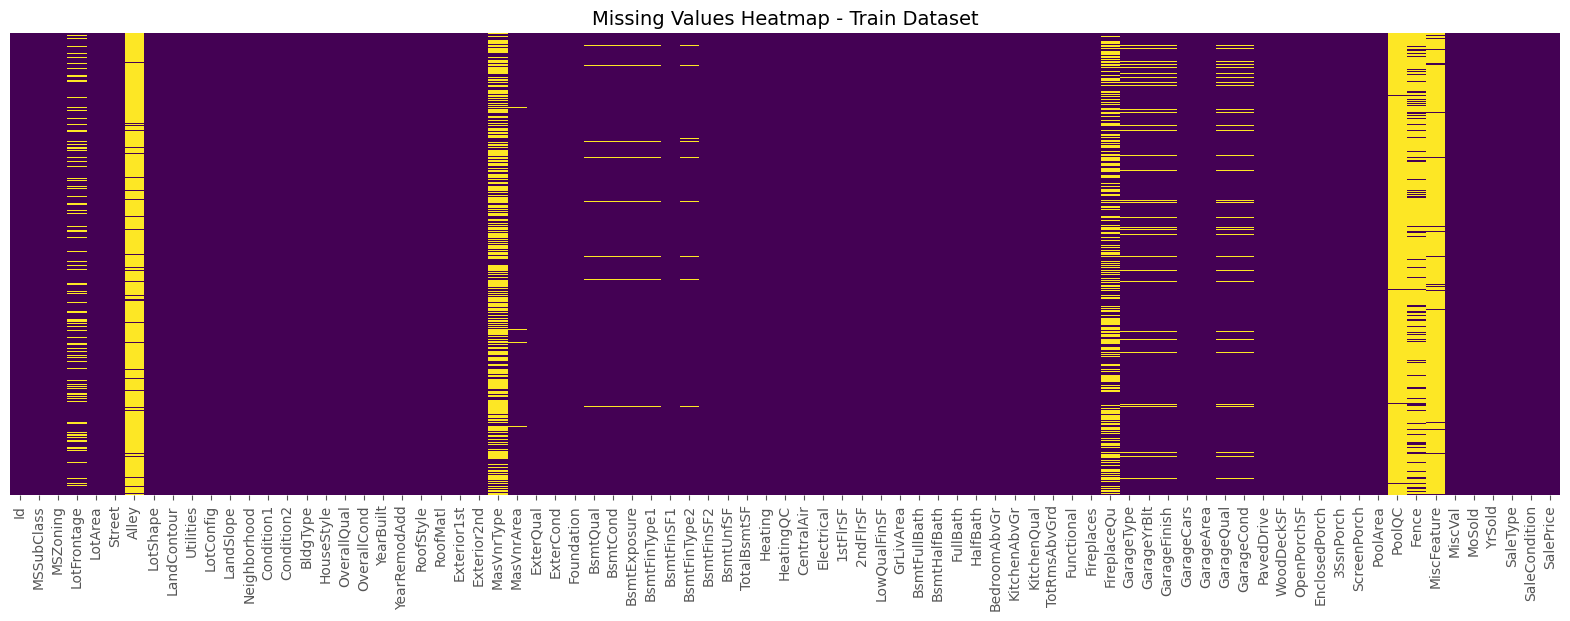

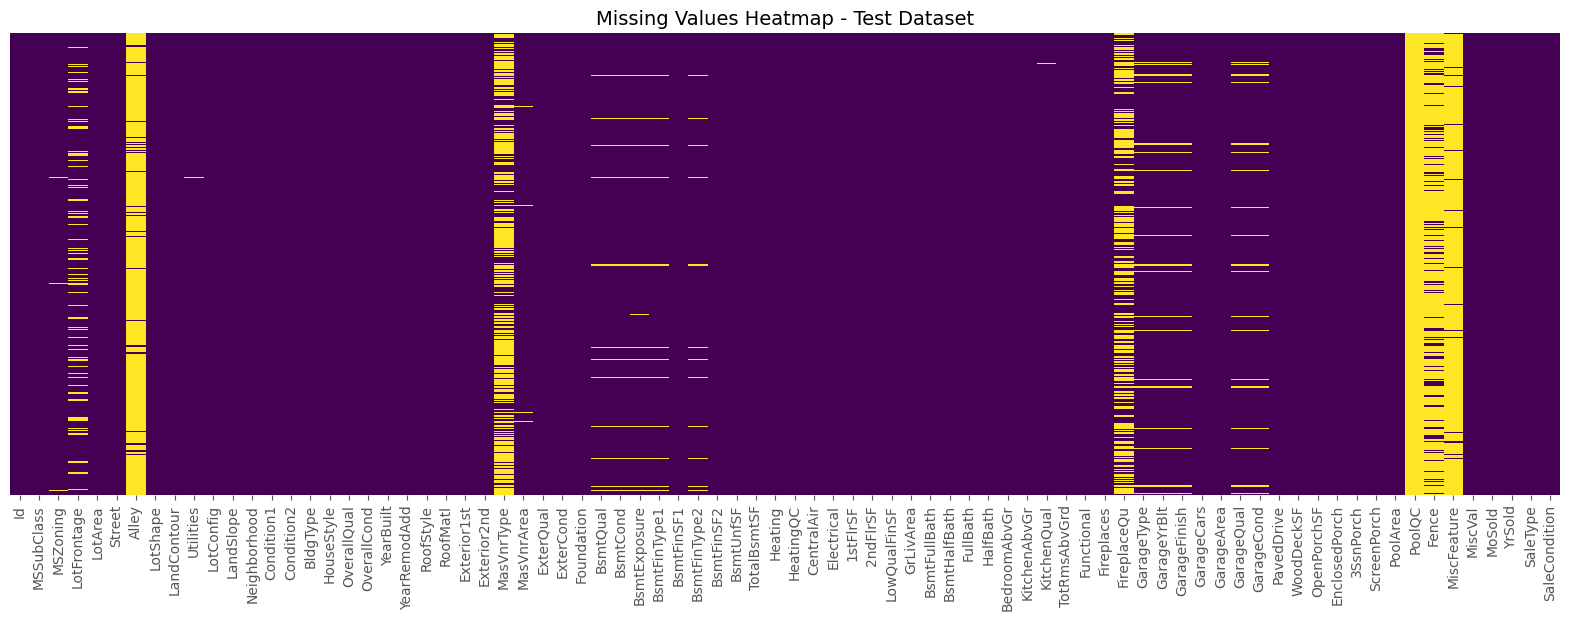

In [15]:
# Function to plot missing values heatmap
def plot_missing_values_heatmap(df, title="Missing Values Heatmap"):
    plt.figure(figsize=(20, 6))
    sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
    plt.title(title, fontsize=14)
    plt.show()

# Generate heatmaps for train and test datasets
plot_missing_values_heatmap(train, "Missing Values Heatmap - Train Dataset")
plot_missing_values_heatmap(test, "Missing Values Heatmap - Test Dataset")


Handling NaN values

In [16]:
# 1. Drop specified columns
columns_to_drop = ["LotFrontage", "Alley", "MasVnrType", "MiscFeature"]
train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)

# 2. Replace NaNs with "None" for categorical features
replace_none_columns = [
    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "FireplaceQu", "GarageType", "GarageYrBlt", "GarageFinish",
    "GarageQual", "GarageCond", "PoolQC", "Fence"
]

train[replace_none_columns] = train[replace_none_columns].fillna("None")
test[replace_none_columns] = test[replace_none_columns].fillna("None")

# 3. Drop rows where 'MasVnrArea' is NaN
train.dropna(subset=["MasVnrArea"], inplace=True)
test.dropna(subset=["MasVnrArea"], inplace=True)

# 4. Drop rows where 'Electrical' is NaN
train.dropna(subset=["Electrical"], inplace=True)

# 5. Drop rows where 'MSZoning' is NaN
test.dropna(subset=["MSZoning"], inplace=True)     

# 6. Drop rows where 'Utilities' is NaN
test.dropna(subset=["Utilities"], inplace=True)   

# 7. Drop rows with NaN in specified columns in the test dataset
columns_to_drop_na_in_test = [
    "Exterior1st", "Exterior2nd", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", 
    "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath", "KitchenQual", "Functional",
    "GarageCars", "GarageArea", "SaleType"
]

test.dropna(subset=columns_to_drop_na_in_test, inplace=True)

# Display the results
print("Missing values after processing (train):")
print(train.isnull().sum().sum())  # Should print 0 if all NaNs are handled

print("\nMissing values after processing (test):")
print(test.isnull().sum().sum())  # Should print 0 if all NaNs are handled

Missing values after processing (train):
0

Missing values after processing (test):
0


Check duplicates

In [17]:
# Check for duplicates in train dataset
train_duplicates = train[train.duplicated()]
print("Duplicates in train dataset:")
print(train_duplicates)

# Check for duplicates in test dataset
test_duplicates = test[test.duplicated()]
print("\nDuplicates in test dataset:")
print(test_duplicates)


Duplicates in train dataset:
Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotArea, Street, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

Duplicates in test dataset:
Empty DataFrame

# Exploratory Data Analysis (EDA)

## Statistical analysis of quantitative features

In [18]:
print("train statistical analysis:")
display(train.drop(columns='Id', errors='ignore').describe())

print("test statistical analysis:")
display(train.drop(columns='Id', errors='ignore').describe())

train statistical analysis:


MSSubClass        LotArea  OverallQual  OverallCond    YearBuilt  \
count  1451.000000    1451.000000  1451.000000  1451.000000  1451.000000   
mean     56.933150   10507.808408     6.093728     5.579600  1971.092350   
std      42.350366    9992.987081     1.381467     1.113415    30.190266   
min      20.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      20.000000    7537.500000     5.000000     5.000000  1954.000000   
50%      50.000000    9477.000000     6.000000     5.000000  1972.000000   
75%      70.000000   11600.000000     7.000000     6.000000  2000.000000   
max     190.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd  MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  \
count   1451.000000  1451.00000  1451.000000  1451.000000  1451.000000   
mean    1984.760165   103.75672   442.274983    46.838043   567.197105   
std       20.651334   181.10815   455.369276   161.777324   442.209192   
min     1950.000000     0.00000     0.000000     0.000000     0.000000   
25%     1966.000000     0.00000     0.000000     0.000000   222.000000   
50%     1993.000000     0.00000   381.000000     0.000000   479.000000   
75%     2004.000000   166.00000   707.000000     0.000000   808.000000   
max     2010.000000  1600.00000  5644.000000  1474.000000  2336.000000   

       TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
count  1451.000000  1451.000000  1451.000000   1451.000000  1451.000000   
mean   1056.310131  1161.551344   346.742247      5.880772  1514.174363   
std     437.914609   385.002532   436.453277     48.771560   525.799521   
min       0.000000   334.000000     0.000000      0.000000   334.000000   
25%     795.000000   882.000000     0.000000      0.000000  1128.000000   
50%     991.000000  1086.000000     0.000000      0.000000  1464.000000   
75%    1297.500000  1391.000000   728.000000      0.000000  1776.000000   
max    6110.000000  4692.000000  2065.000000    572.000000  5642.000000   

       BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  \
count   1451.000000   1451.000000  1451.000000  1451.000000   1451.000000   
mean       0.423846      0.057891     1.562371     0.381116      2.866988   
std        0.518842      0.239449     0.550301     0.502574      0.815086   
min        0.000000      0.000000     0.000000     0.000000      0.000000   
25%        0.000000      0.000000     1.000000     0.000000      2.000000   
50%        0.000000      0.000000     2.000000     0.000000      3.000000   
75%        1.000000      0.000000     2.000000     1.000000      3.000000   
max        3.000000      2.000000     3.000000     2.000000      8.000000   

       KitchenAbvGr  TotRmsAbvGrd   Fireplaces   GarageCars   GarageArea  \
count   1451.000000   1451.000000  1451.000000  1451.000000  1451.000000   
mean       1.046175      6.516885     0.612681     1.764990   472.525155   
std        0.219571      1.626576     0.643443     0.748728   214.171752   
min        0.000000      2.000000     0.000000     0.000000     0.000000   
25%        1.000000      5.000000     0.000000     1.000000   327.500000   
50%        1.000000      6.000000     1.000000     2.000000   478.000000   
75%        1.000000      7.000000     1.000000     2.000000   576.000000   
max        3.000000     14.000000     3.000000     4.000000  1418.000000   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1451.000000  1451.000000    1451.000000  1451.000000  1451.000000   
mean     94.412819    46.422467      21.952447     3.430737    15.154376   
std     125.436852    66.060150      61.108223    29.406940    55.917522   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    24.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000

test statistical analysis:


MSSubClass        LotArea  OverallQual  OverallCond    YearBuilt  \
count  1451.000000    1451.000000  1451.000000  1451.000000  1451.000000   
mean     56.933150   10507.808408     6.093728     5.579600  1971.092350   
std      42.350366    9992.987081     1.381467     1.113415    30.190266   
min      20.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      20.000000    7537.500000     5.000000     5.000000  1954.000000   
50%      50.000000    9477.000000     6.000000     5.000000  1972.000000   
75%      70.000000   11600.000000     7.000000     6.000000  2000.000000   
max     190.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd  MasVnrArea   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  \
count   1451.000000  1451.00000  1451.000000  1451.000000  1451.000000   
mean    1984.760165   103.75672   442.274983    46.838043   567.197105   
std       20.651334   181.10815   455.369276   161.777324   442.209192   
min     1950.000000     0.00000     0.000000     0.000000     0.000000   
25%     1966.000000     0.00000     0.000000     0.000000   222.000000   
50%     1993.000000     0.00000   381.000000     0.000000   479.000000   
75%     2004.000000   166.00000   707.000000     0.000000   808.000000   
max     2010.000000  1600.00000  5644.000000  1474.000000  2336.000000   

       TotalBsmtSF     1stFlrSF     2ndFlrSF  LowQualFinSF    GrLivArea  \
count  1451.000000  1451.000000  1451.000000   1451.000000  1451.000000   
mean   1056.310131  1161.551344   346.742247      5.880772  1514.174363   
std     437.914609   385.002532   436.453277     48.771560   525.799521   
min       0.000000   334.000000     0.000000      0.000000   334.000000   
25%     795.000000   882.000000     0.000000      0.000000  1128.000000   
50%     991.000000  1086.000000     0.000000      0.000000  1464.000000   
75%    1297.500000  1391.000000   728.000000      0.000000  1776.000000   
max    6110.000000  4692.000000  2065.000000    572.000000  5642.000000   

       BsmtFullBath  BsmtHalfBath     FullBath     HalfBath  BedroomAbvGr  \
count   1451.000000   1451.000000  1451.000000  1451.000000   1451.000000   
mean       0.423846      0.057891     1.562371     0.381116      2.866988   
std        0.518842      0.239449     0.550301     0.502574      0.815086   
min        0.000000      0.000000     0.000000     0.000000      0.000000   
25%        0.000000      0.000000     1.000000     0.000000      2.000000   
50%        0.000000      0.000000     2.000000     0.000000      3.000000   
75%        1.000000      0.000000     2.000000     1.000000      3.000000   
max        3.000000      2.000000     3.000000     2.000000      8.000000   

       KitchenAbvGr  TotRmsAbvGrd   Fireplaces   GarageCars   GarageArea  \
count   1451.000000   1451.000000  1451.000000  1451.000000  1451.000000   
mean       1.046175      6.516885     0.612681     1.764990   472.525155   
std        0.219571      1.626576     0.643443     0.748728   214.171752   
min        0.000000      2.000000     0.000000     0.000000     0.000000   
25%        1.000000      5.000000     0.000000     1.000000   327.500000   
50%        1.000000      6.000000     1.000000     2.000000   478.000000   
75%        1.000000      7.000000     1.000000     2.000000   576.000000   
max        3.000000     14.000000     3.000000     4.000000  1418.000000   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1451.000000  1451.000000    1451.000000  1451.000000  1451.000000   
mean     94.412819    46.422467      21.952447     3.430737    15.154376   
std     125.436852    66.060150      61.108223    29.406940    55.917522   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    24.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000

**Feature-by-Feature Analysis:**

1. **MSSubClass**:
   - **Description**: The building class.
   - **Range**: From 20 (smallest building) to 190 (largest).
   - **Insight**: It’s an important feature that categorizes building types. The values provide insight into the overall size and style of houses.

2. **LotArea**:
   - **Description**: Lot size in square feet.
   - **Range**: From 1,300 to 215,245 square feet, with a mean of 10,507.81.
   - **Insight**: Shows significant variation. Larger homes tend to be on larger plots, which may influence the price. There might be outliers that should be examined further.

3. **OverallQual**:
   - **Description**: Overall quality of the house, rated on a scale from 1 (lowest) to 10 (highest).
   - **Range**: From 1 to 10, with a mean of 6.09.
   - **Insight**: This feature represents the general condition of the house. Most houses fall between ratings of 5-7, showing that average-quality homes are most common in the dataset.

4. **OverallCond**:
   - **Description**: Overall condition of the house, rated on a scale from 1 (lowest) to 9 (highest).
   - **Range**: From 1 to 9, with a mean of 5.58.
   - **Insight**: Similar to `OverallQual`, this feature assesses the condition of the house but is likely focused more on its physical upkeep and structure.

5. **YearBuilt**:
   - **Description**: Year the house was originally constructed.
   - **Range**: From 1872 to 2010, with a mean of 1971.
   - **Insight**: Houses are mostly from the 20th century, with a peak in the late 20th century. Older homes may require more maintenance, while newer homes may have better features and amenities.

6. **YearRemodAdd**:
   - **Description**: Year the house was last remodeled or added to.
   - **Range**: From 1950 to 2010, with a mean of 1984.76.
   - **Insight**: Shows when homes were last updated. It can help identify if a house is more modern or if it might need additional renovations.

7. **MasVnrArea**:
   - **Description**: Masonry veneer area in square feet (e.g., brick or stone exterior).
   - **Range**: From 0 to 1,600, with a mean of 103.76 square feet.
   - **Insight**: Some houses may not have any masonry veneer, as indicated by the 0 value. This feature may impact the aesthetic and value of the house.

8. **BsmtFinSF1, BsmtFinSF2**:
   - **Description**: Area of finished basement space, in square feet (two different sections of the basement).
   - **Range**: `BsmtFinSF1` ranges from 0 to 5,644 sq. ft., and `BsmtFinSF2` ranges from 0 to 1,474 sq. ft.
   - **Insight**: Basement space is valuable, especially in colder climates. These features show the size of the finished basement, which can add living space to the house.

9. **BsmtUnfSF**:
    - **Description**: Area of unfinished basement space in square feet.
    - **Range**: From 0 to 2,336 sq. ft.
    - **Insight**: Unfinished basements are common in older homes, and this feature can give insight into the potential for future renovations.

10. **TotalBsmtSF**:
    - **Description**: Total basement area (sum of finished and unfinished areas).
    - **Range**: From 0 to 6,110 sq. ft.
    - **Insight**: A larger basement area is often associated with larger homes, and it can significantly affect the price and livability.

11. **1stFlrSF**:
    - **Description**: Area of the first floor in square feet.
    - **Range**: From 334 to 4,692 sq. ft., with a mean of 1,056 sq. ft.
    - **Insight**: Indicates the primary living area of the home. Larger first-floor spaces often correlate with larger, more expensive homes.

12. **2ndFlrSF**:
    - **Description**: Area of the second floor in square feet.
    - **Range**: From 0 to 2,065 sq. ft., with a mean of 346.74 sq. ft.
    - **Insight**: Smaller than the first floor in most homes, but it can still add substantial living space to a multi-story house.

13. **LowQualFinSF**:
    - **Description**: Low-quality finished area in square feet.
    - **Range**: From 0 to 572 sq. ft.
    - **Insight**: Generally, this feature is 0 for most homes, indicating that high-quality finishes are more common in the dataset.

14. **GrLivArea**:
    - **Description**: Above-ground living area in square feet.
    - **Range**: From 334 to 5,642 sq. ft., with a mean of 1,514 sq. ft.
    - **Insight**: A key feature influencing house value; the more above-ground living space, the higher the potential price.

15. **BsmtFullBath, BsmtHalfBath**:
    - **Description**: Number of full and half bathrooms in the basement.
    - **Range**: `BsmtFullBath` from 0 to 3, and `BsmtHalfBath` from 0 to 2.
    - **Insight**: More bathrooms in the basement could add value, particularly in homes with fully finished basements.

16. **FullBath, HalfBath**:
    - **Description**: Number of full and half bathrooms above grade.
    - **Range**: `FullBath` from 0 to 3, and `HalfBath` from 0 to 2.
    - **Insight**: The number of bathrooms significantly impacts the house’s functionality and overall comfort.

17. **BedroomAbvGr**:
    - **Description**: Number of bedrooms above ground.
    - **Range**: From 1 to 8, with a mean of 2.87.
    - **Insight**: More bedrooms typically mean a larger house and higher price. The majority of houses in the dataset have 3–4 bedrooms.

18. **KitchenAbvGr**:
    - **Description**: Number of kitchens above ground.
    - **Range**: From 1 to 3.
    - **Insight**: Generally, houses have one kitchen, though larger homes may have multiple.

19. **TotRmsAbvGrd**:
    - **Description**: Total rooms above grade (excluding bathrooms).
    - **Range**: From 2 to 14, with a mean of 6.52.
    - **Insight**: More rooms correlate with larger, more expensive homes.

20. **Fireplaces**:
    - **Description**: Number of fireplaces in the house.
    - **Range**: From 0 to 3, with a mean of 0.61.
    - **Insight**: Not all houses have fireplaces, but their presence can increase the value and desirability of a property.

21. **GarageCars, GarageArea**:
    - **Description**: Number of cars the garage can hold and the area of the garage in square feet.
    - **Range**: `GarageCars` from 0 to 4, with a mean of 1.76, and `GarageArea` from 0 to 1,418 sq. ft., with a mean of 472.53.
    - **Insight**: Larger garages with higher car capacity are often associated with higher-priced homes.

22. **WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch**:
    - **Description**: Various porch and deck areas in square feet.
    - **Insight**: Homes with more outdoor space (decks, porches) may be valued higher, particularly in areas with good weather.

23. **PoolArea**:
    - **Description**: Pool area in square feet.
    - **Range**: From 0 to 1,500 sq. ft.
    - **Insight**: A pool can add significant value to a home, but it’s only present in a small number of homes.

24. **MiscVal**:
    - **Description**: Miscellaneous feature value.
    - **Insight**: This can represent additional features that don’t fit other categories.

27. **MoSold, YrSold**:
    - **Description**: Month and year of sale.
    - **Range**: `MoSold` from 1 to 12, and `YrSold` from 2006 to 2010.
    - **Insight**: The time of year and the economy may affect home prices, with certain months or years possibly showing higher sales prices.

27. **SalePrice**:
    - **Description**: Sale price of the house.
    - **Range**: From 34,900 to 755,000, with a mean of 180,624.10.
    - **Insight**: This is the target variable, and it is significantly influenced by factors like location, size, age, and condition of the home.

---

**Conclusion:**
The dataset contains a mix of categorical and continuous variables, each contributing to the value and appeal of a house. Features like `OverallQual`, `GrLivArea`, and `SalePrice` are likely to have the most significant impact on predicting house prices, while others like `BsmtFinSF1`, `Fireplaces`, and `GarageCars` could provide additional insight into the overall value and functionality of the house.

## Grapfics and summaries

### Quantitative features


Train Continuous Feature Analysis:


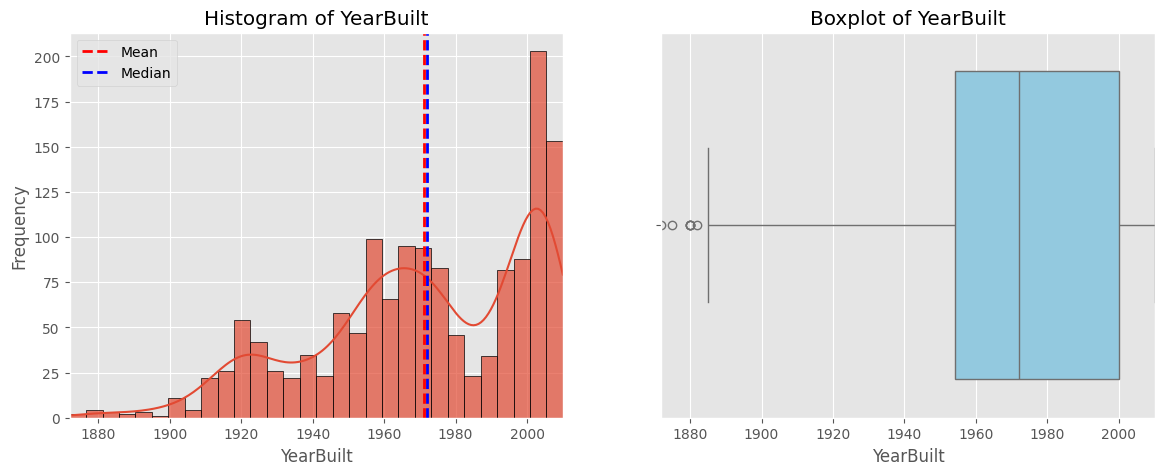

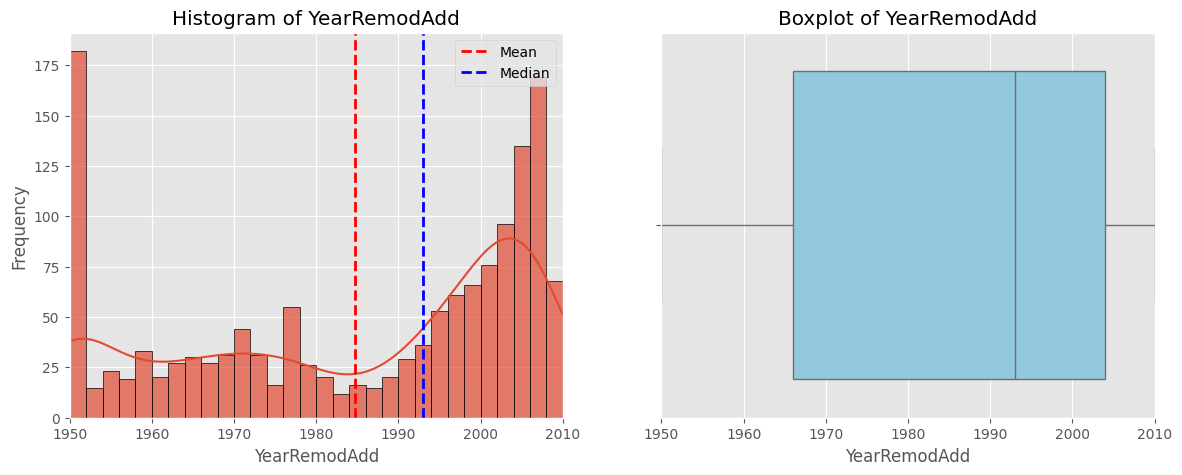

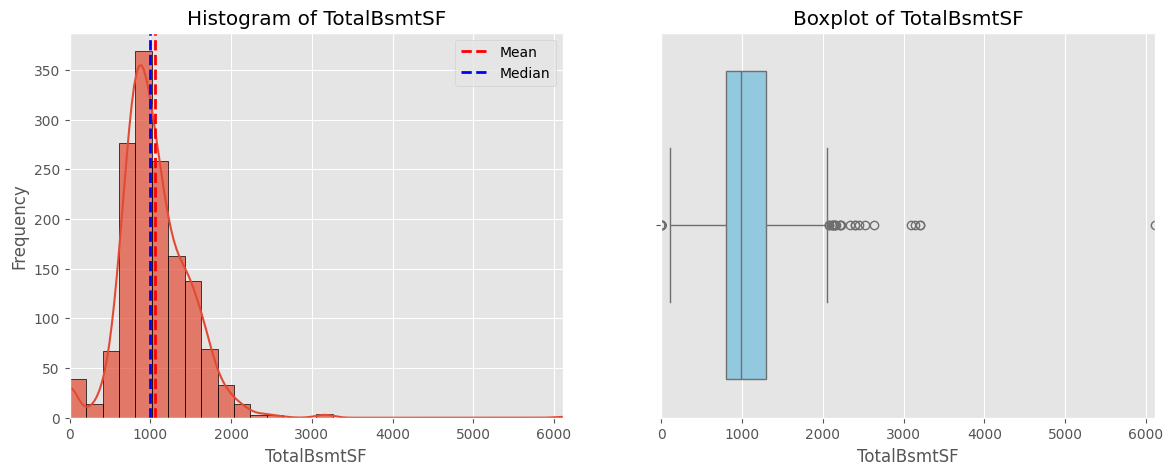

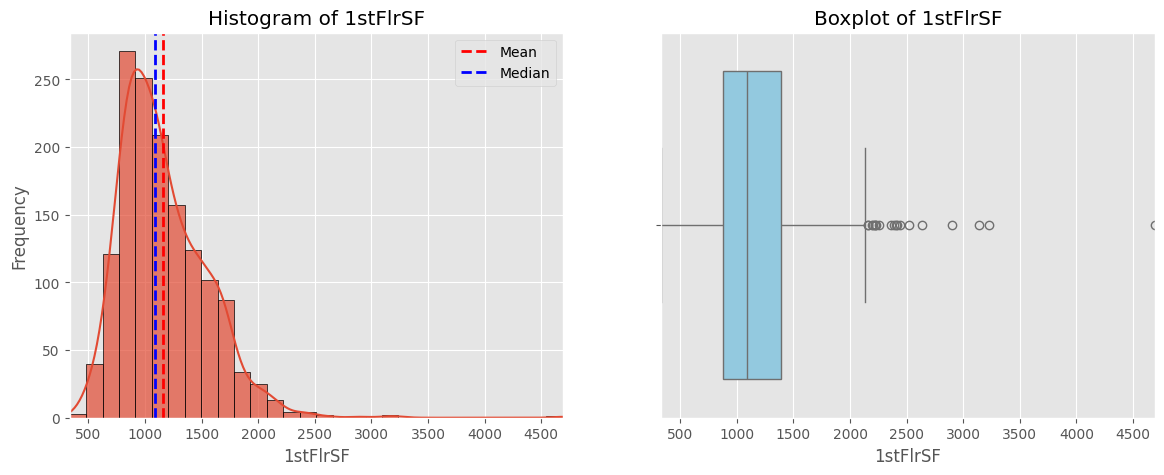

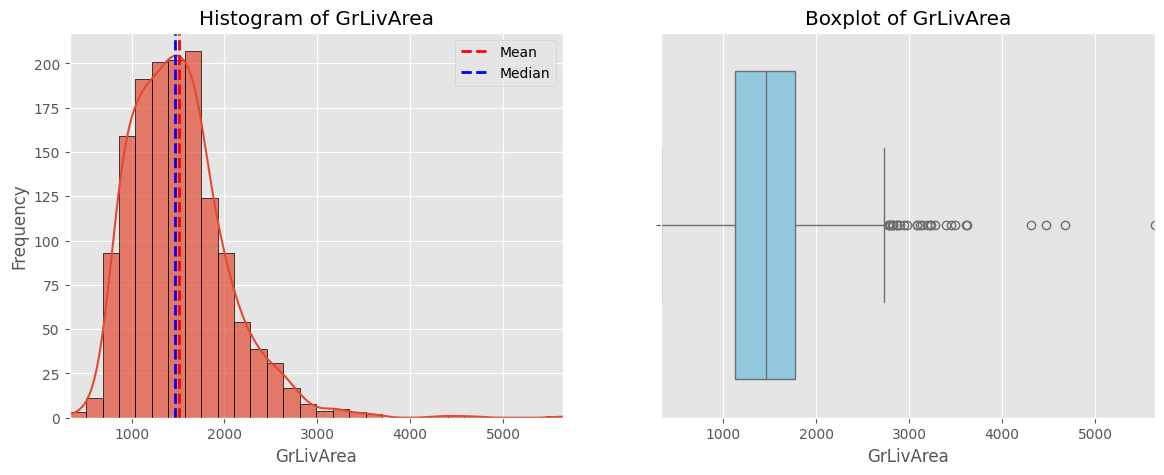

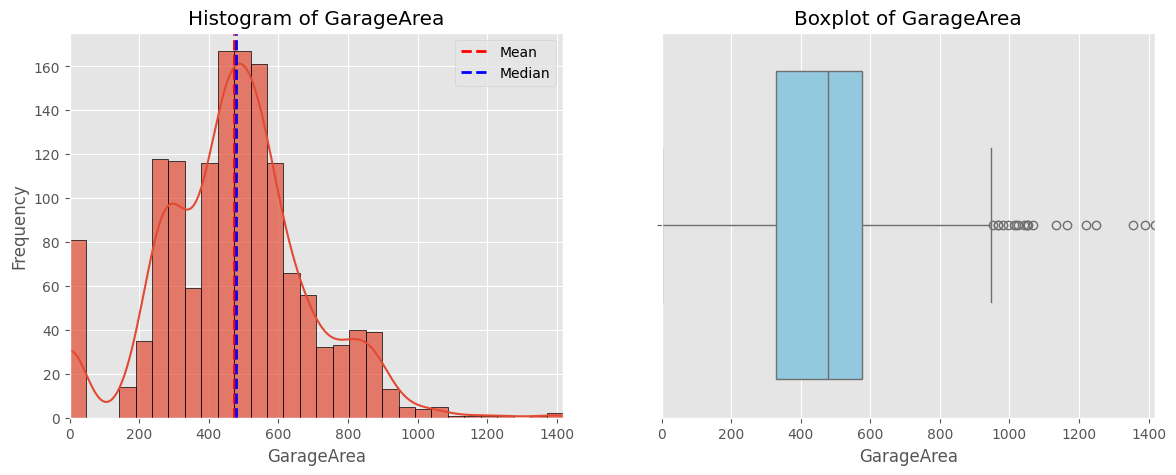

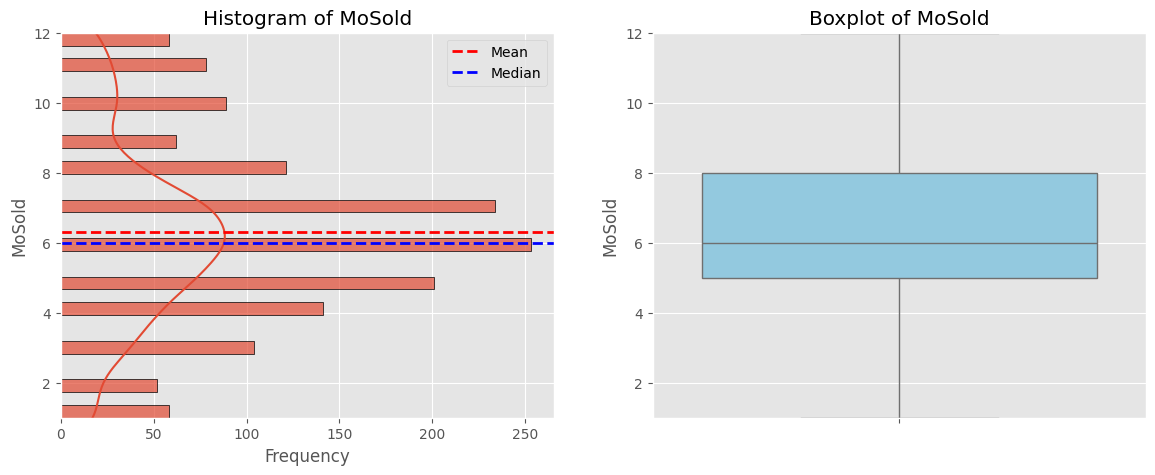

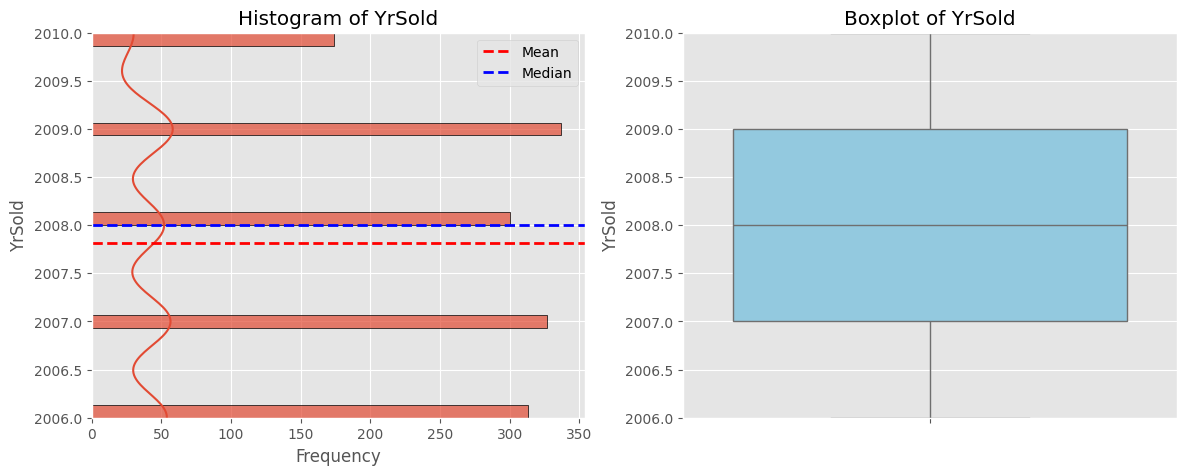

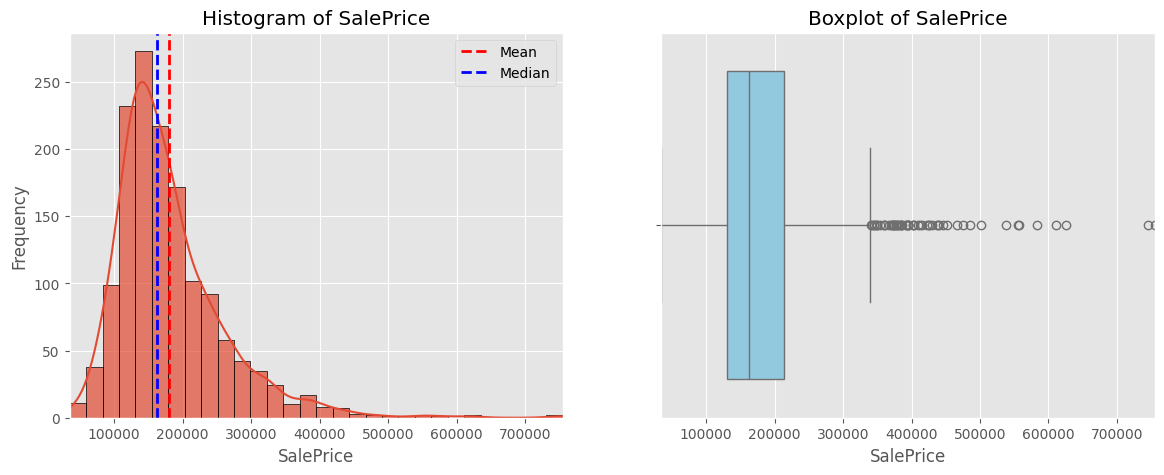


Test Continuous Feature Analysis:


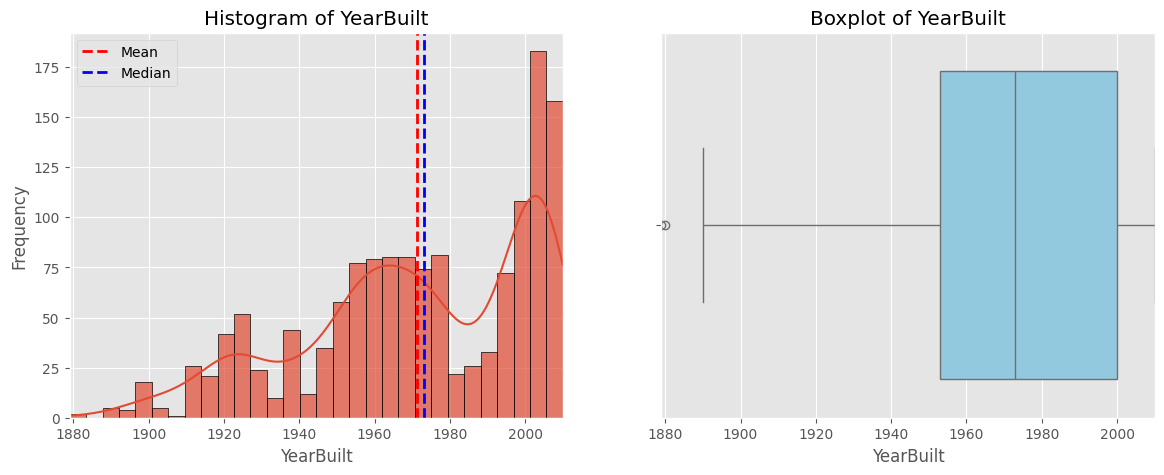

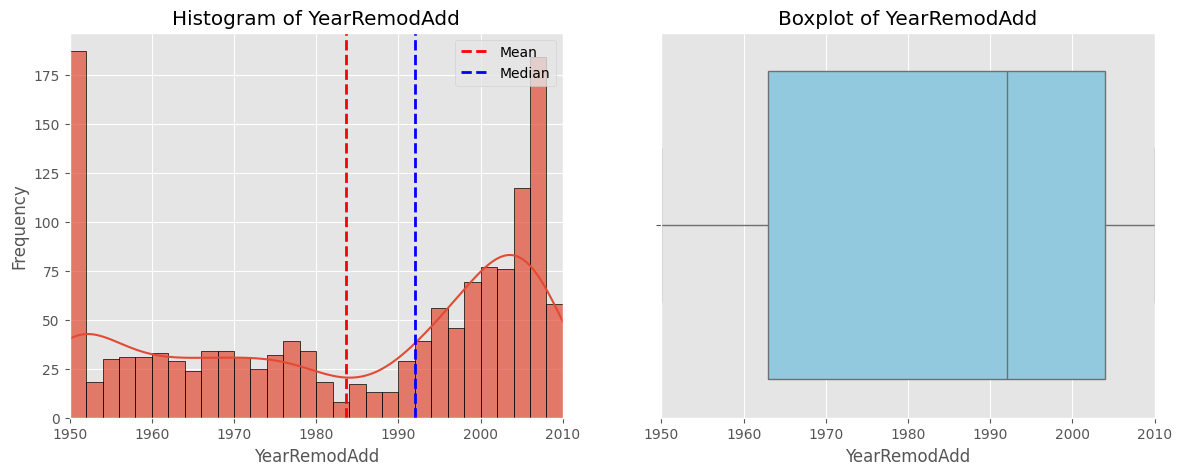

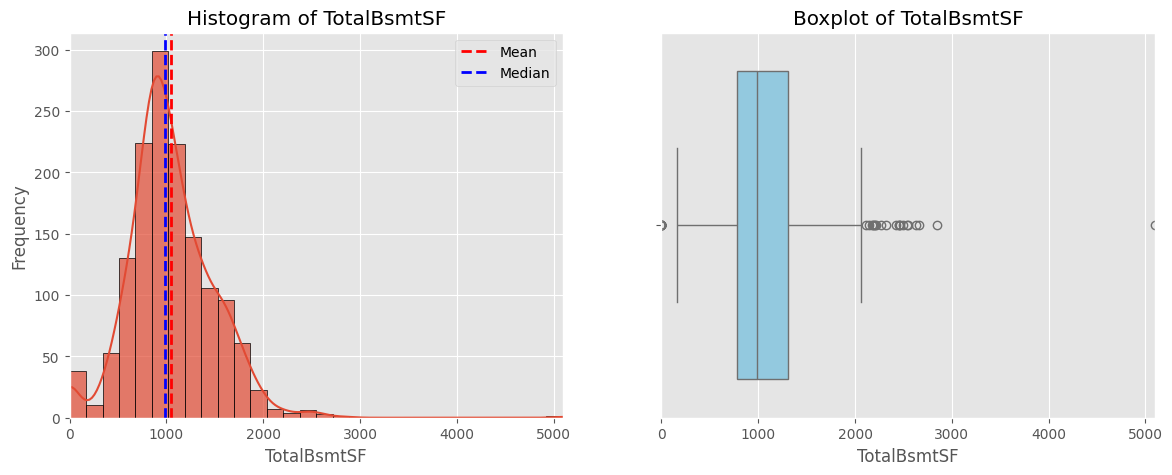

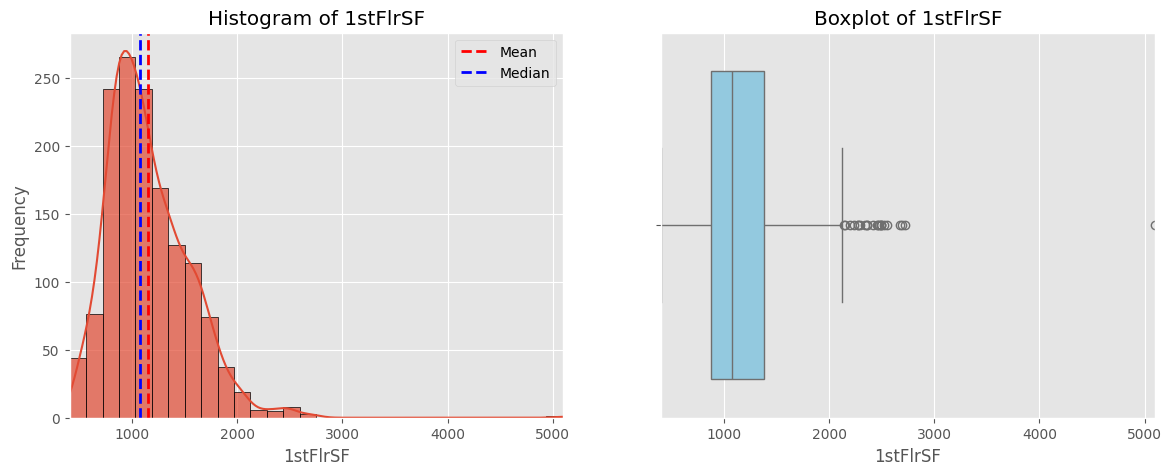

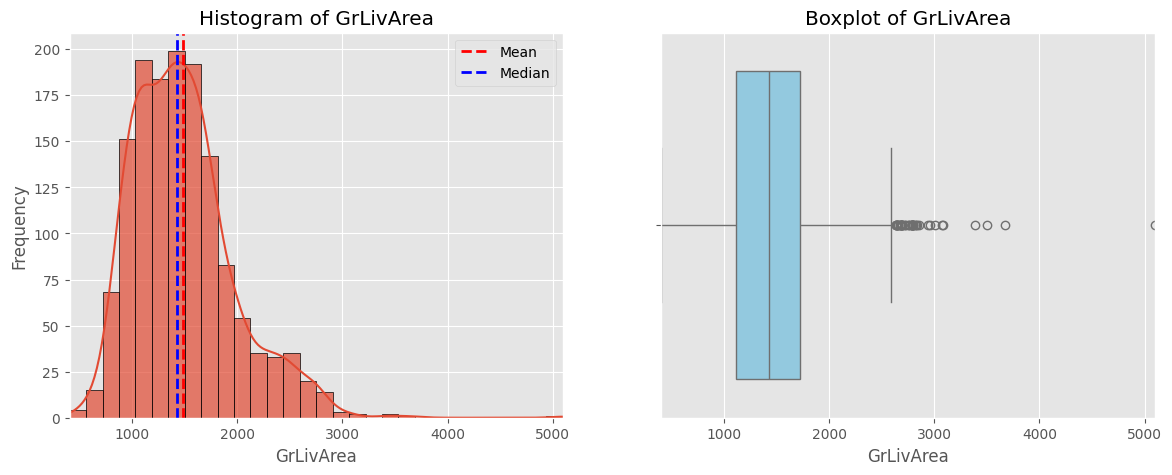

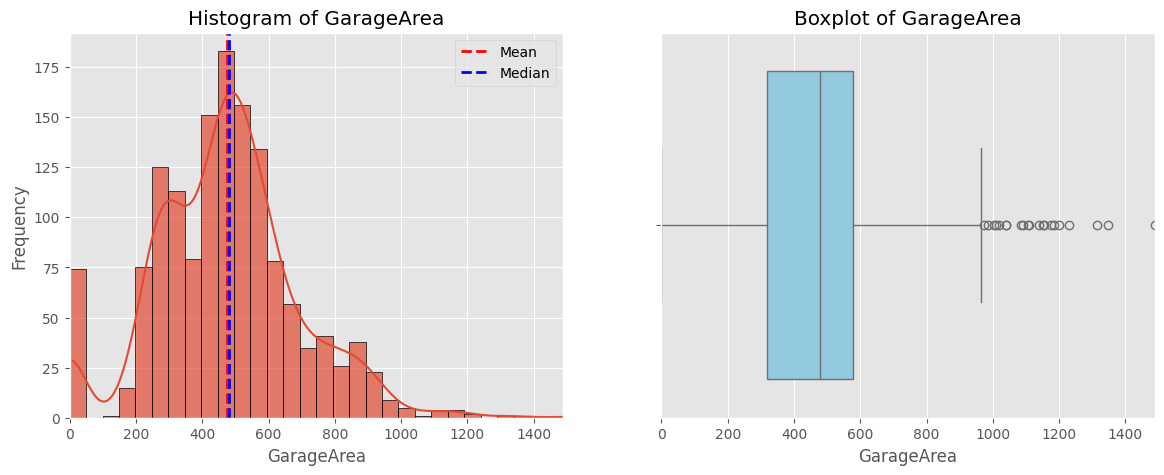

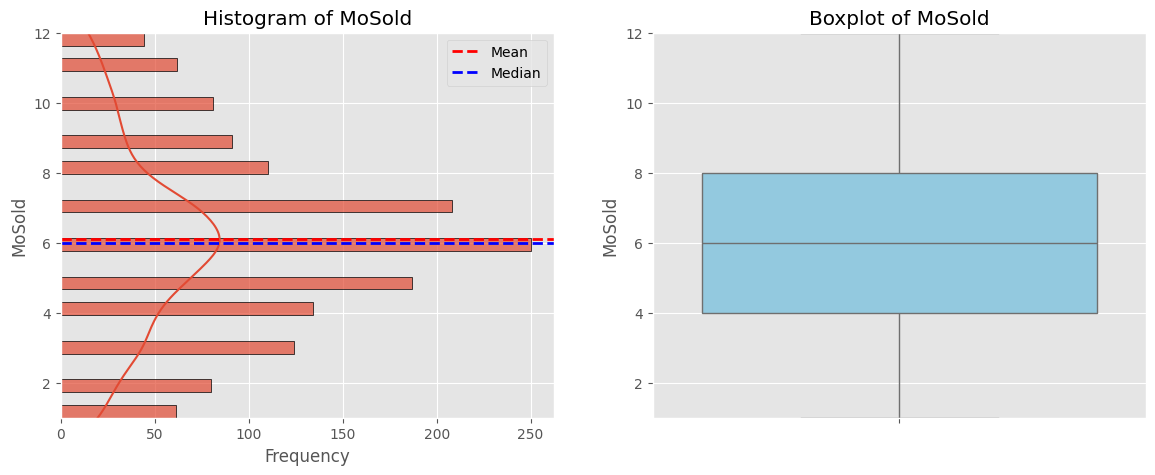

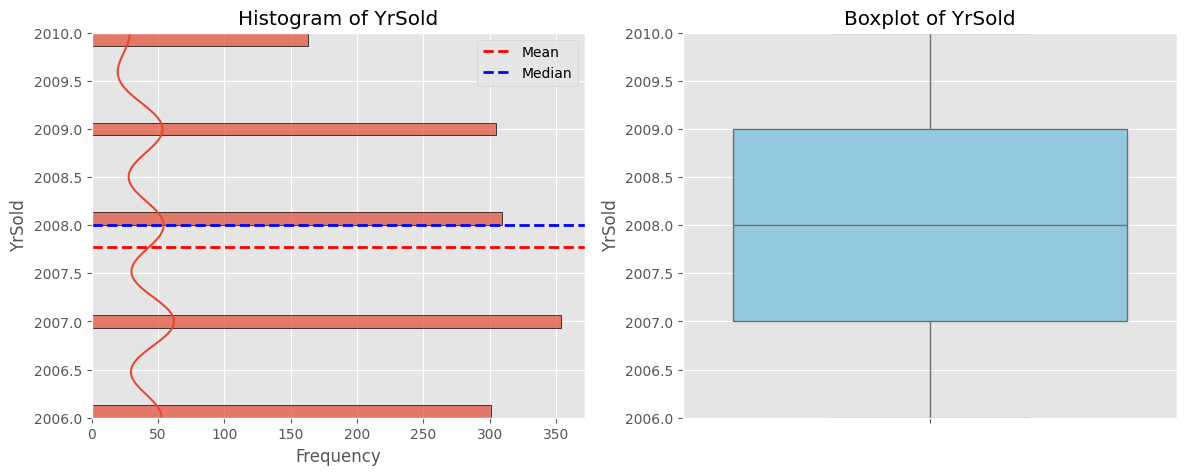

In [ ]:
# Set the plot style
plt.style.use("ggplot")

# Define categorical and ordinal features (to exclude)
categorical_features = [
    "MSSubClass", "MSZoning", "Street", "LotShape", "LandContour", "Utilities",
    "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle",
    "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "Foundation",
    "Heating", "Electrical", "GarageType", "SaleType", "SaleCondition"
]

ordinal_features = [
    "OverallQual", "OverallCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageFinish",
    "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", "Functional",
    "ExterQual", "ExterCond", "LandSlope", "LotShape", "Utilities", "CentralAir"
]

count_based_features = [
    "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr",
    "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars"
]

# Define binning rules
binning_rules = {
    "MasVnrArea": [-1, 0, 60, 200, 300, 500, np.inf],
    "BsmtUnfSF": [-1, 0, 500, 750, 1000, 1300, 1750, np.inf],
    "BsmtFinSF1": [-1, 0, 300, 600, 1500, np.inf],
    "BsmtFinSF2": [-1, 0, 200, 580, 1150, np.inf],
    "2ndFlrSF": [-1, 0, 500, 1000, 1500, np.inf],
    "WoodDeckSF": [-1, 0, 100, 300, 500, np.inf],
    "OpenPorchSF": [-1, 0, 30, 130, np.inf],
    "EnclosedPorch": [-1, 0, 100, 260, np.inf],
    "ScreenPorch": [-1, 0, 90, 220, 350, np.inf],
    "LotArea": [-1, 7500, 12500, 17500, 22500, np.inf]
}

mostly_zeros = [
    "LowQualFinSF", "3SsnPorch"
]

# Apply binning for selected features
for col, bins in binning_rules.items():
    train[f"{col}_Bin"] = pd.cut(train[col], bins=bins, labels=False)
    test[f"{col}_Bin"] = pd.cut(test[col], bins=bins, labels=False)

# Create binary indicators for PoolArea and MiscVal
train["Has_Pool"] = (train["PoolArea"] > 0).astype(int)
test["Has_Pool"] = (test["PoolArea"] > 0).astype(int)

train["Has_MiscVal"] = (train["MiscVal"] > 0).astype(int)
test["Has_MiscVal"] = (test["MiscVal"] > 0).astype(int)

# Remove original continuous features that were binned
binned_features = list(binning_rules.keys()) + ["PoolArea", "MiscVal"]
train.drop(columns=binned_features, inplace=True)
test.drop(columns=binned_features, inplace=True)

# Combine features to exclude from continuous analysis
excluded_features = set(categorical_features + ordinal_features + count_based_features + mostly_zeros)

# Define features that should be plotted horizontally
horizontal_features = ["MoSold", "YrSold"]

def plot_continuous_features(data, dataset_name):
    """
    Plots histograms and boxplots for continuous numerical features only.

    Parameters:
    - data: DataFrame containing the dataset.
    - dataset_name: Name of the dataset (for labeling).
    """
    # Select only continuous numerical features (exclude categorical, ordinal, binned)
    continuous_columns = [
        col for col in data.select_dtypes(include=["int64", "float64"]).columns
        if col not in excluded_features and "_Bin" not in col and "Has_" not in col and col.lower() != "id"
    ]

    print(f"\n{dataset_name} Continuous Feature Analysis:")

    for col in continuous_columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Drop NaN values to avoid plotting issues
        col_data = data[col].dropna()

        # Get the min and max for consistent x-axis limits
        xmin, xmax = col_data.min(), col_data.max()

        if col in horizontal_features:
            # Horizontal bar chart for MoSold and YrSold
            sns.histplot(y=col_data, bins=30, kde=True, ax=axes[0], edgecolor="black", alpha=0.7)
            axes[0].axhline(col_data.mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")
            axes[0].axhline(col_data.median(), color='blue', linestyle='dashed', linewidth=2, label="Median")
            axes[0].set_title(f"Histogram of {col}")
            axes[0].set_ylabel(col)
            axes[0].set_xlabel("Frequency")
            axes[0].set_ylim(xmin, xmax)
            axes[0].legend()

            sns.boxplot(y=col_data, ax=axes[1], color="skyblue")
            axes[1].set_title(f"Boxplot of {col}")
            axes[1].set_ylim(xmin, xmax)

        else:
            # Standard vertical histogram
            sns.histplot(col_data, bins=30, kde=True, ax=axes[0], edgecolor="black", alpha=0.7)
            axes[0].axvline(col_data.mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")
            axes[0].axvline(col_data.median(), color='blue', linestyle='dashed', linewidth=2, label="Median")
            axes[0].set_title(f"Histogram of {col}")
            axes[0].set_xlabel(col)
            axes[0].set_ylabel("Frequency")
            axes[0].set_xlim(xmin, xmax)
            axes[0].legend()

            sns.boxplot(x=col_data, ax=axes[1], color="skyblue")
            axes[1].set_title(f"Boxplot of {col}")
            axes[1].set_xlim(xmin, xmax)

        plt.show()

# Generate plots for continuous features in both datasets
plot_continuous_features(train, "Train")
plot_continuous_features(test, "Test")

### **Conclusions on Quantitative Features Based on Transformations and Analysis:**

**1. General Observations:**
- **Most features are not normally distributed**, which may impact machine learning models' performance.
- **Outliers** were detected in several features, including `TotalBsmtSF`, `1stFlrSF`, `GrLivArea`, `GarageArea`, and `SalePrice`.
- Some features contain **a cluster of zero values**, suggesting a categorical representation might be beneficial (e.g., `GarageArea`, `TotalBsmtSF`).

---

**2. Analysis of Individual Features:**

**Year-based Features**
- **`YearBuilt` (Year the house was built)**:  
  - The majority of houses were built **from 1990 onwards**.
  - The second most common range is **1945-1980**.
  - Houses built **before 1945** are less frequent.
  - The oldest houses (pre-1900) are **extremely rare**.

- **`YearRemodAdd` (Year of remodeling/renovation)**:  
  - A significant number of houses were **remodeled in 1950**.
  - Most renovations occurred **between 1990 and 2010**.
  - A **small peak around 1977**.
  - Other years appear **less frequently**.

**Area-related Features**
- **`TotalBsmtSF` (Total basement area) and `1stFlrSF` (First floor area)**:  
  - The majority of values fall **between 0 and 2000 sq. ft**.
  - **Values above 3200 sq. ft are considered outliers**.

- **`GrLivArea` (Above-ground living area)**:  
  - Most data points are within **0-2800 sq. ft**.
  - **Values exceeding 2800 sq. ft are classified as outliers**.

- **`GarageArea` (Garage area size)**:  
  - **A significant number of homes have no garage** (value = 0).
  - Most garages range between **180 and 880 sq. ft**.
  - **Garage areas above 880 sq. ft are outliers**.

**Sale Date Features**
- **`MoSold` (Month Sold) and `YrSold` (Year Sold)**:  
  - **No detected outliers**.
  - Sales are **evenly distributed across years and months**.

**Target Variable**
- **`SalePrice` (Sale price of the house)**:  
  - Most houses are sold within the range of **0 to 340,000 dollars**.
  - **Values above 340,000 are considered outliers**.

---

In [20]:
# Create binary features for basement and garage
train["Has_Basement"] = (train["TotalBsmtSF"] > 0).astype(int)
test["Has_Basement"] = (test["TotalBsmtSF"] > 0).astype(int)

train["Has_Garage"] = (train["GarageArea"] > 0).astype(int)
test["Has_Garage"] = (test["GarageArea"] > 0).astype(int)

# Create a single categorical feature for house age
def categorize_house_age(year):
    if year < 1980:
        return "Old"
    elif year >= 1990:
        return "Modern"
    else:
        return "Standard"

train["House_Age"] = train["YearBuilt"].apply(categorize_house_age)
test["House_Age"] = test["YearBuilt"].apply(categorize_house_age)

# Create a new binary feature for pool presence based on PoolQC
train["Has_Pool"] = (train["PoolQC"] != "None").astype(int)
test["Has_Pool"] = (test["PoolQC"] != "None").astype(int)

### Categorical features

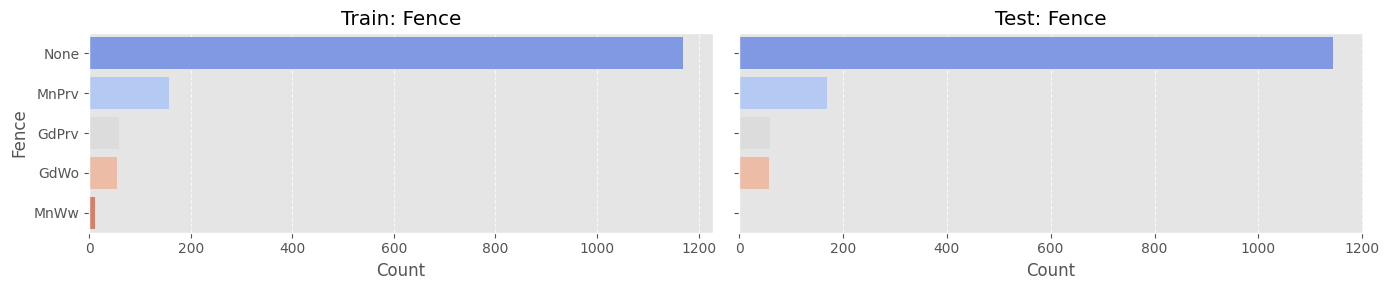

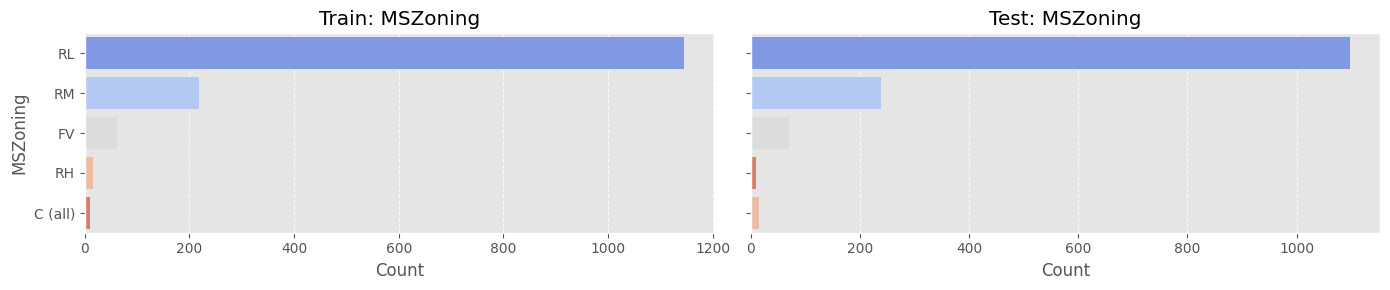

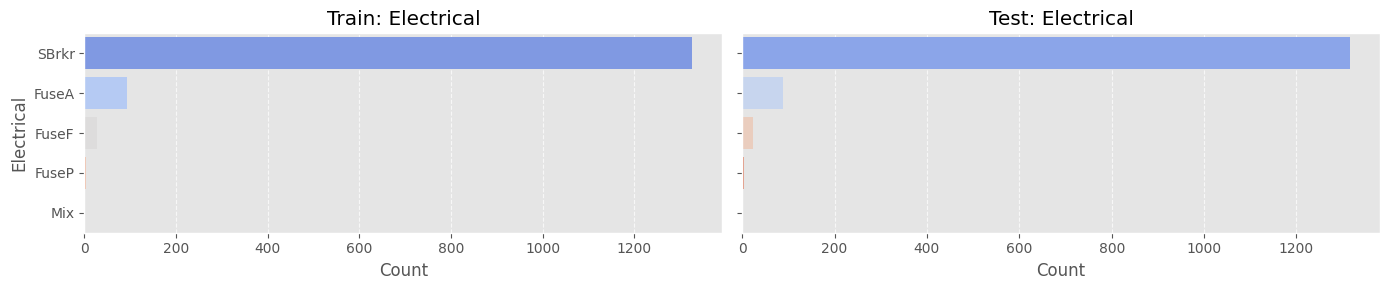

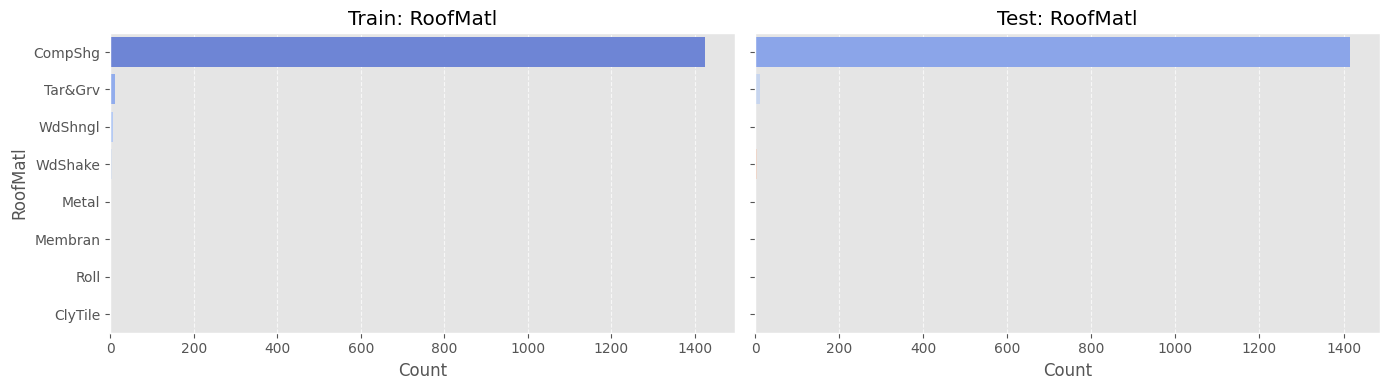

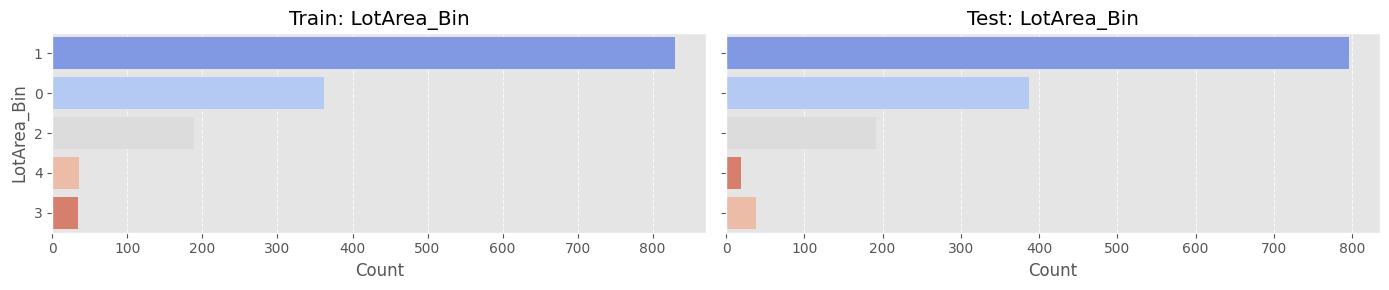

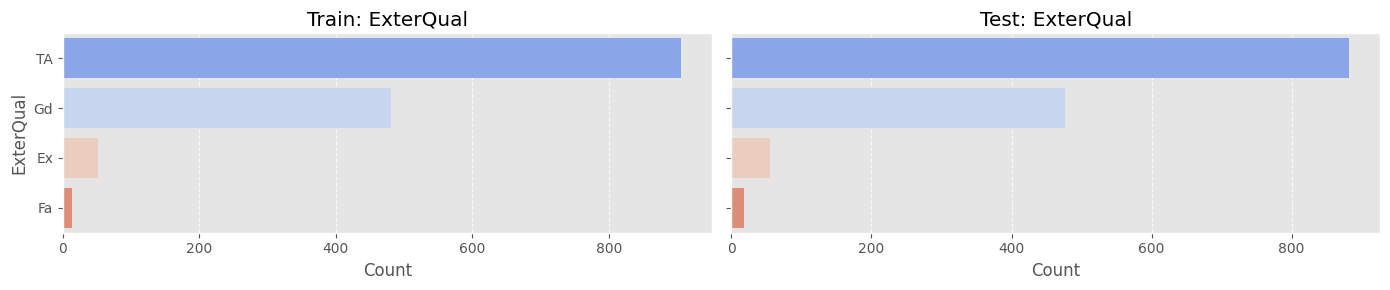

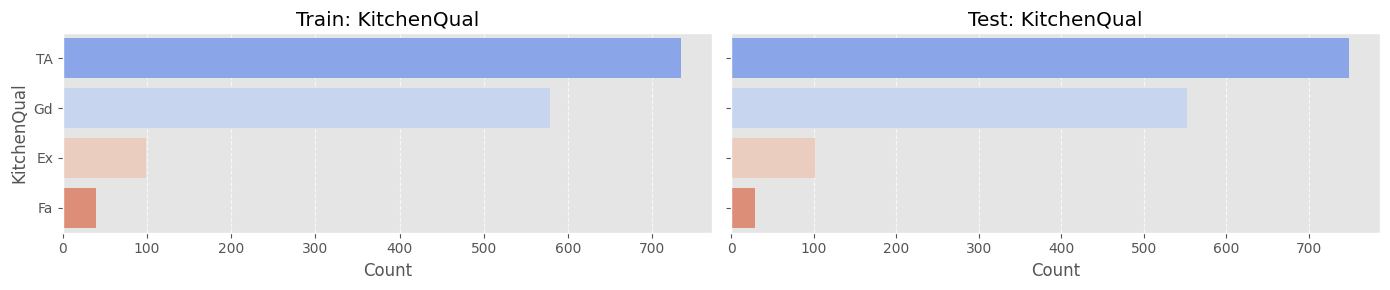

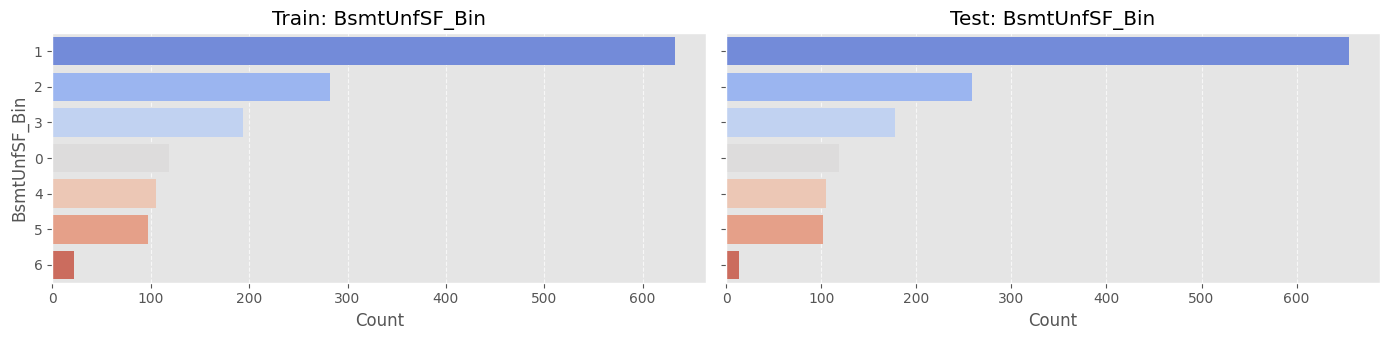

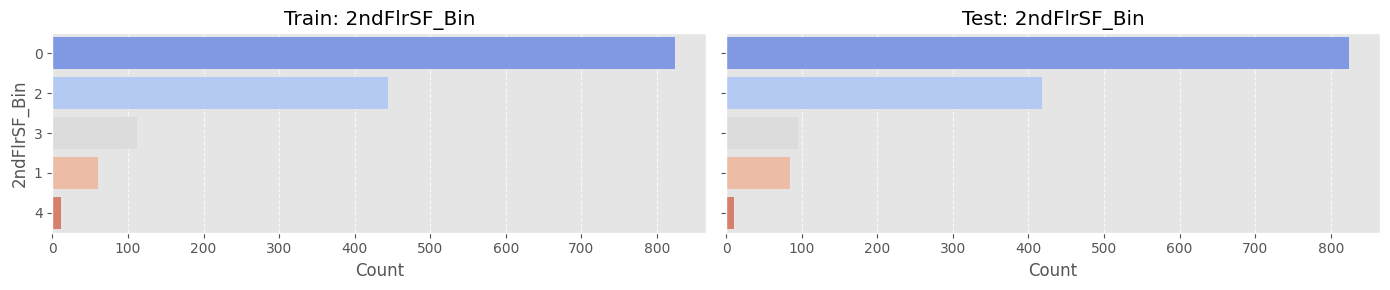

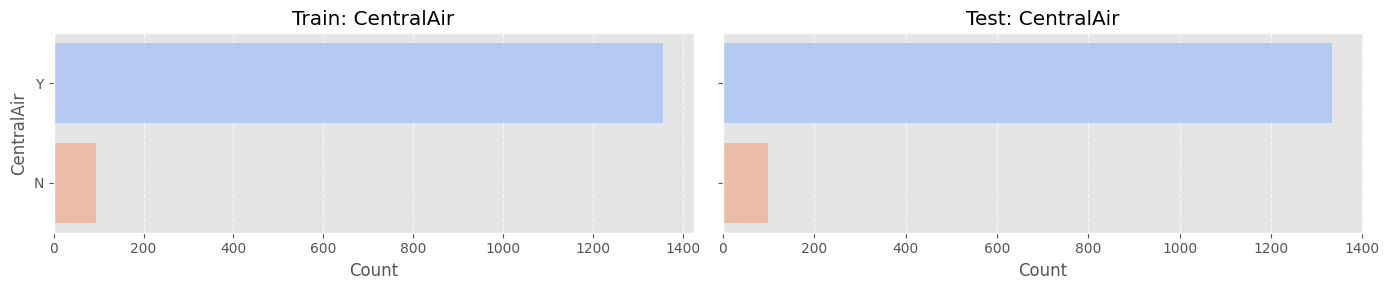

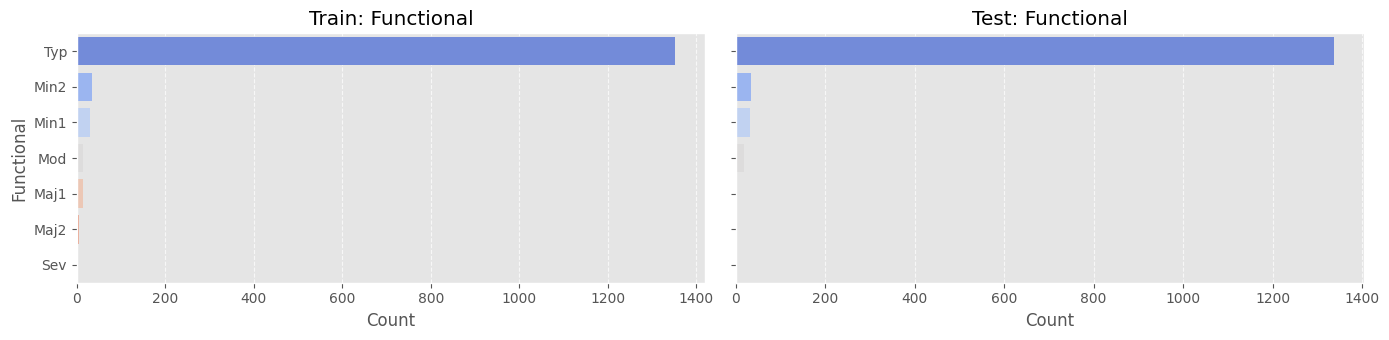

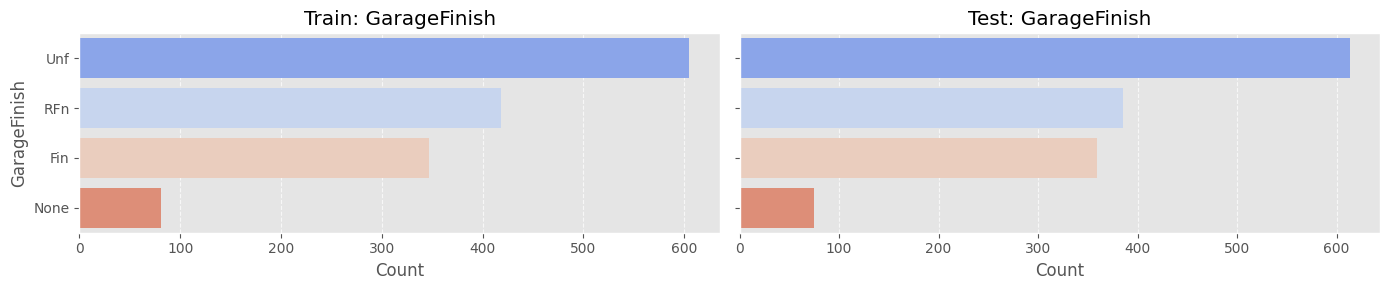

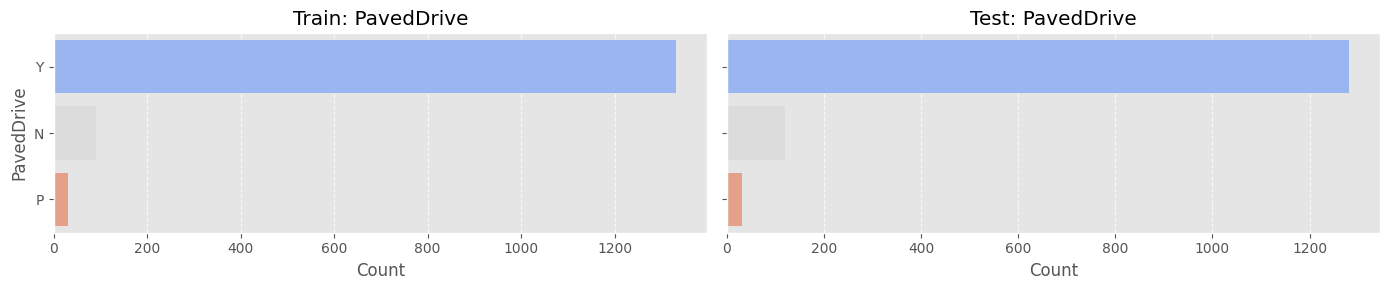

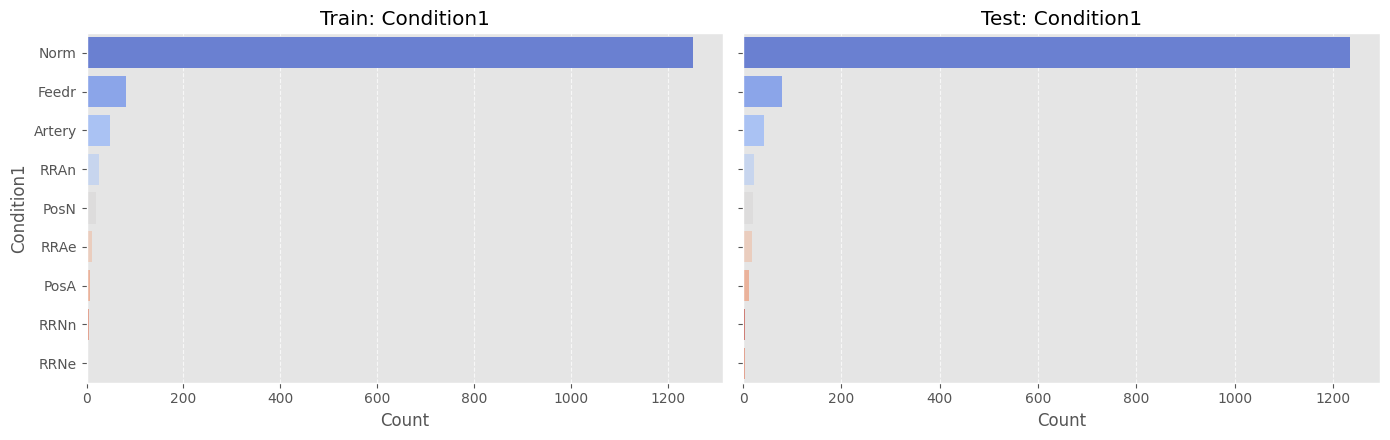

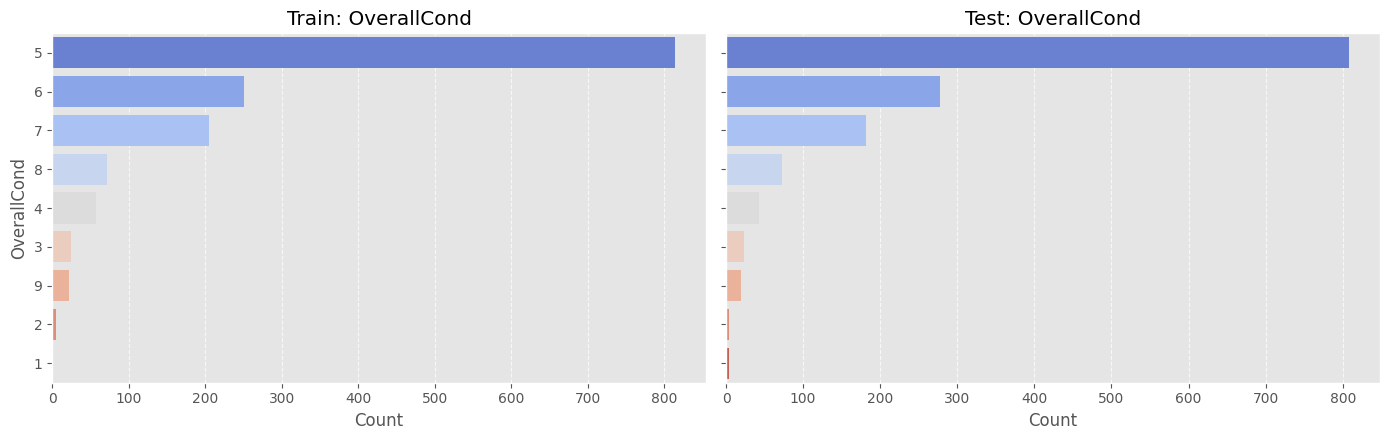

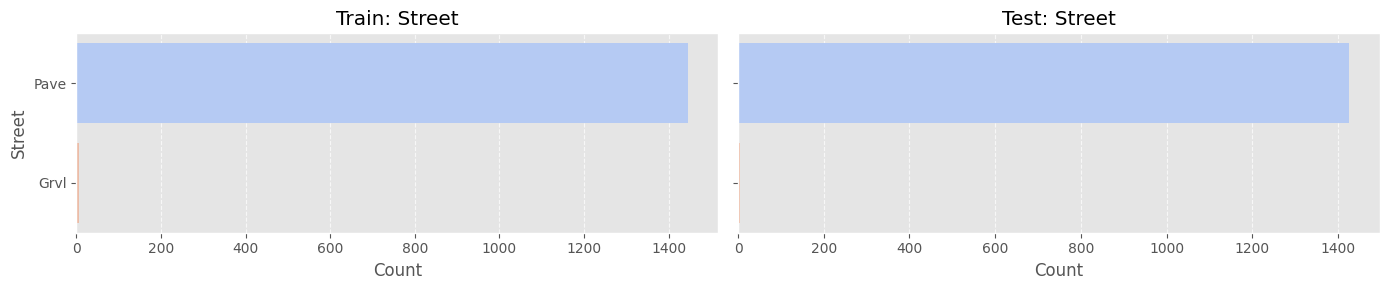

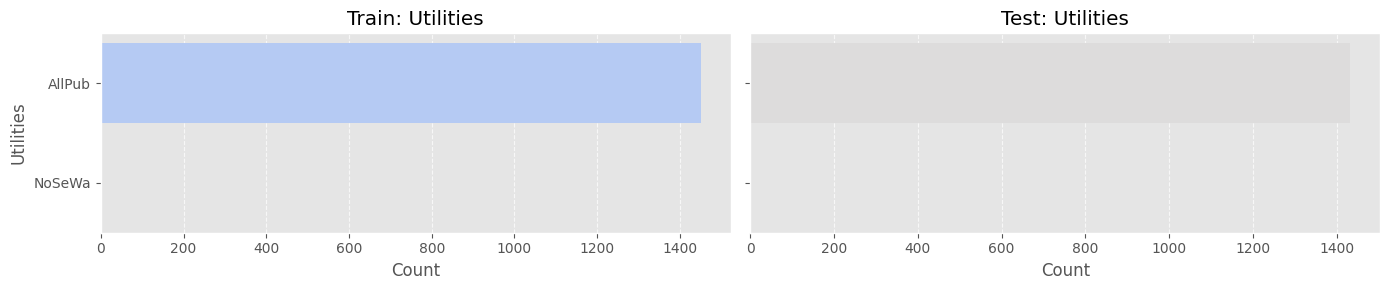

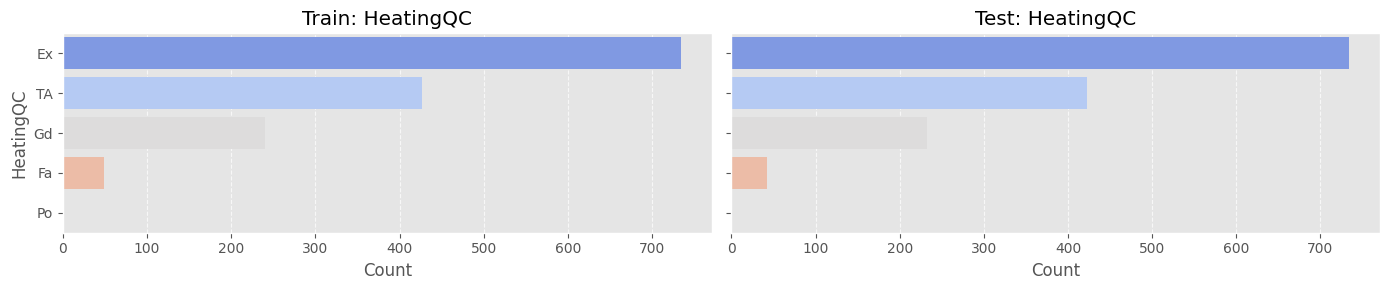

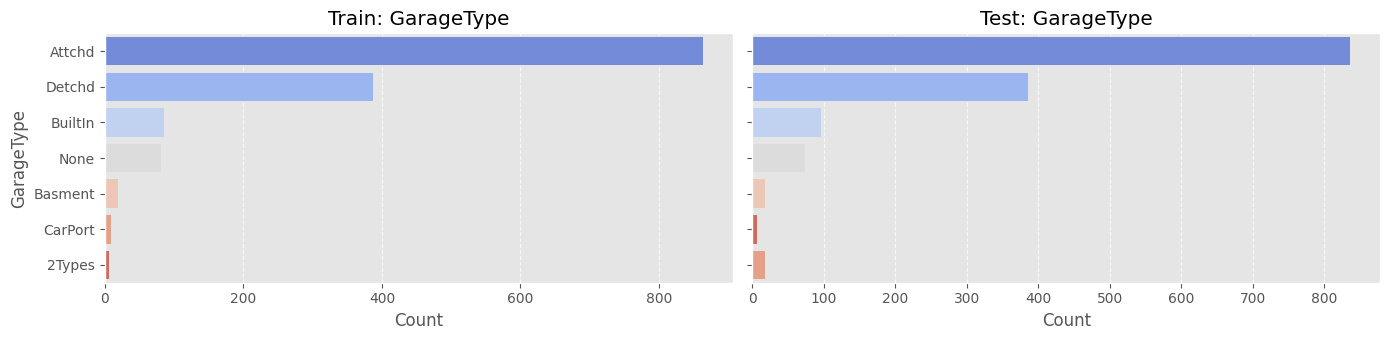

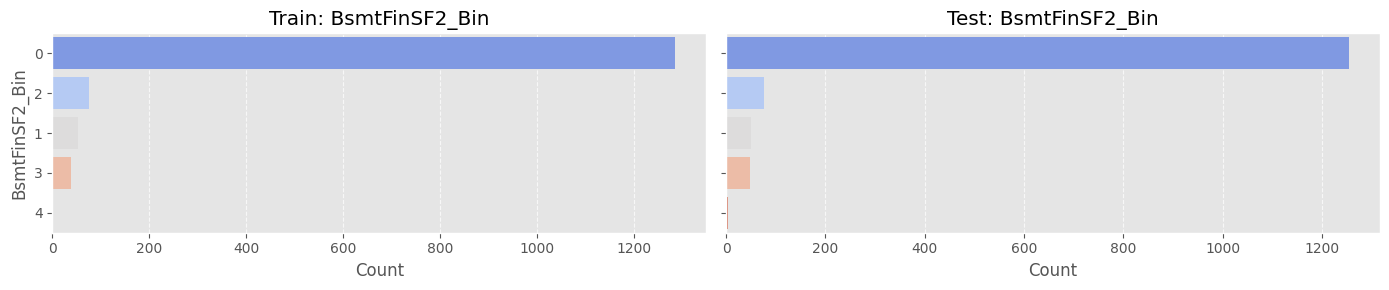

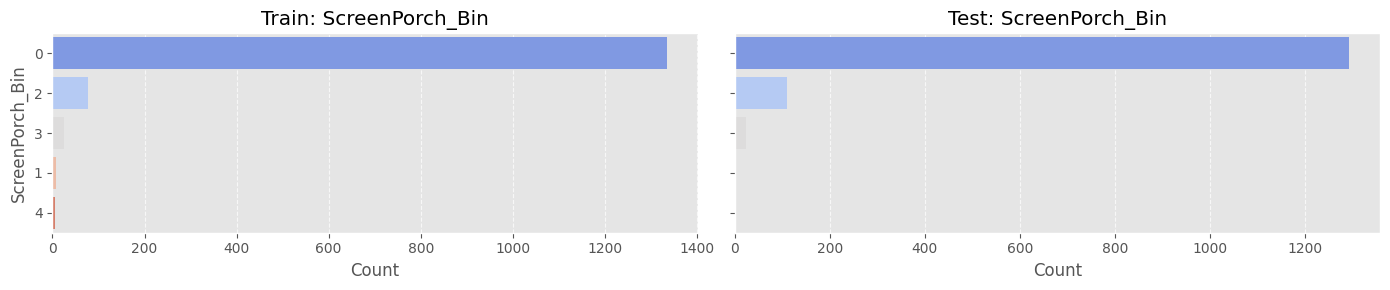

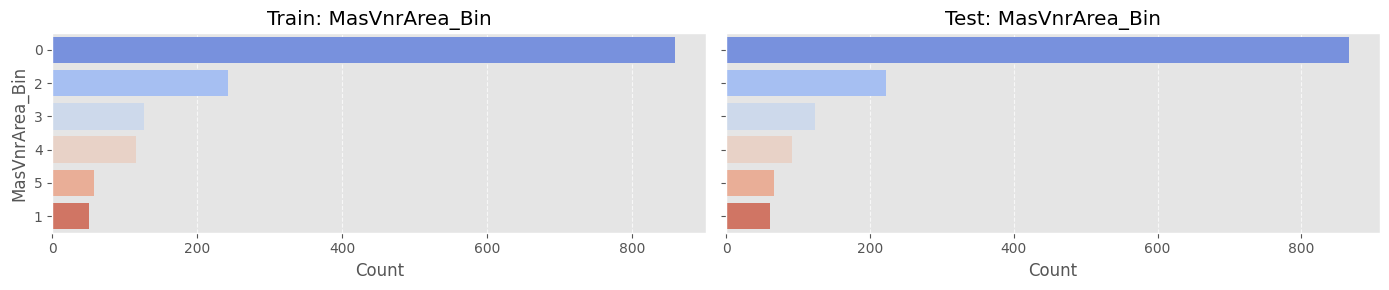

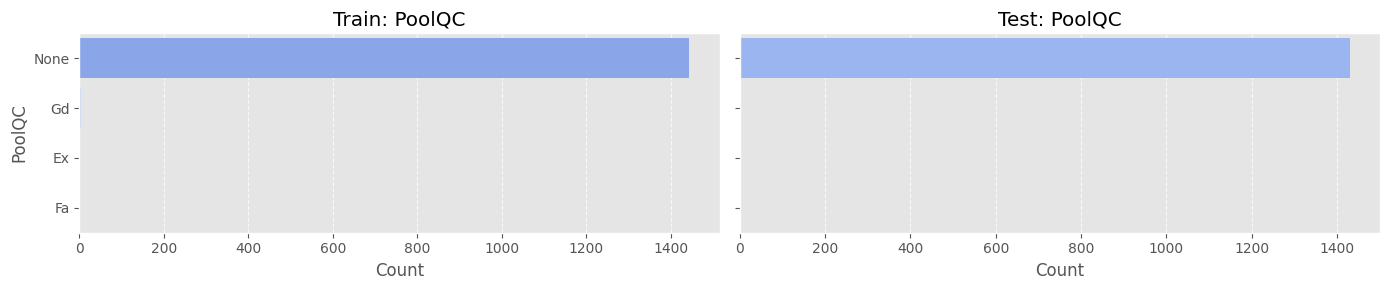

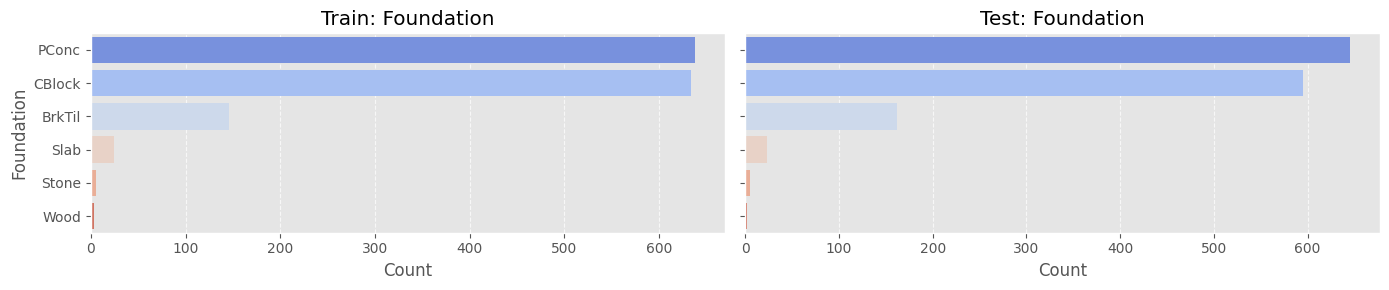

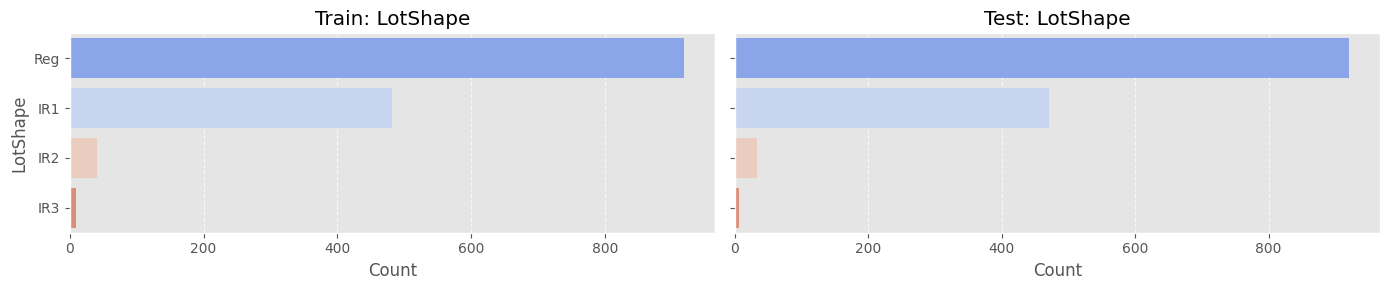

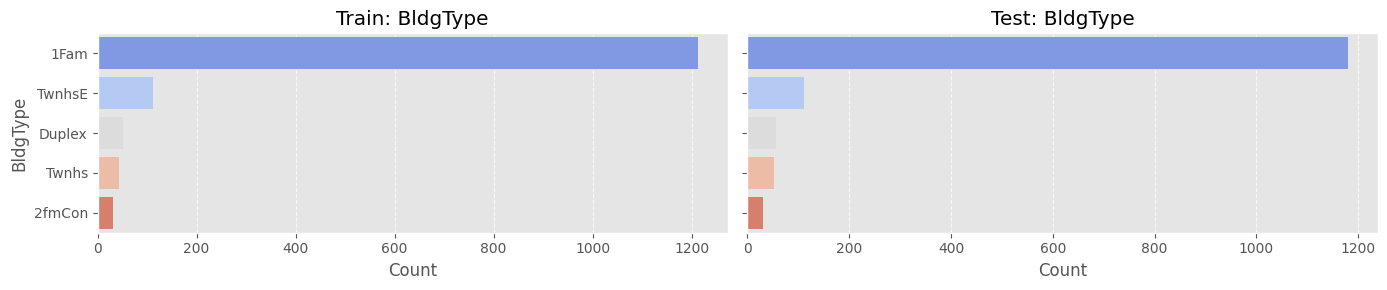

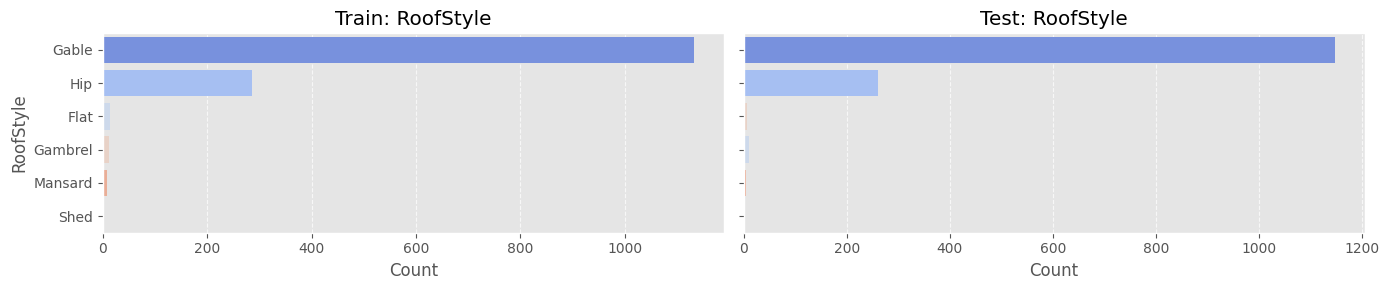

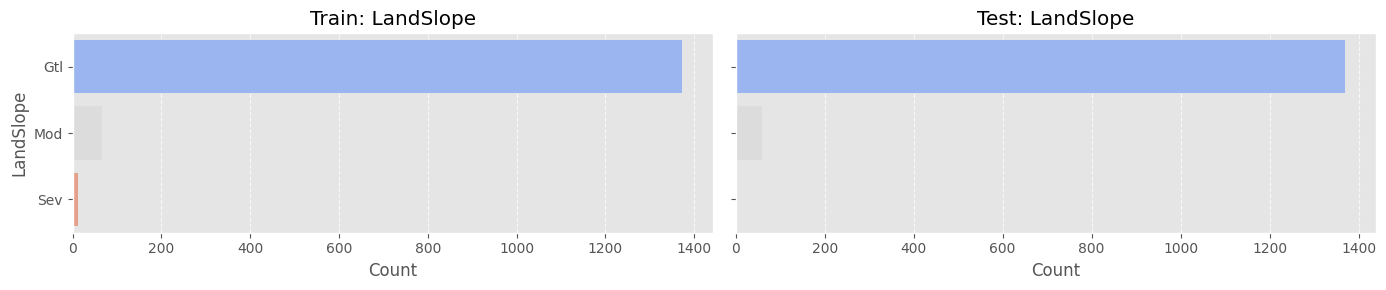

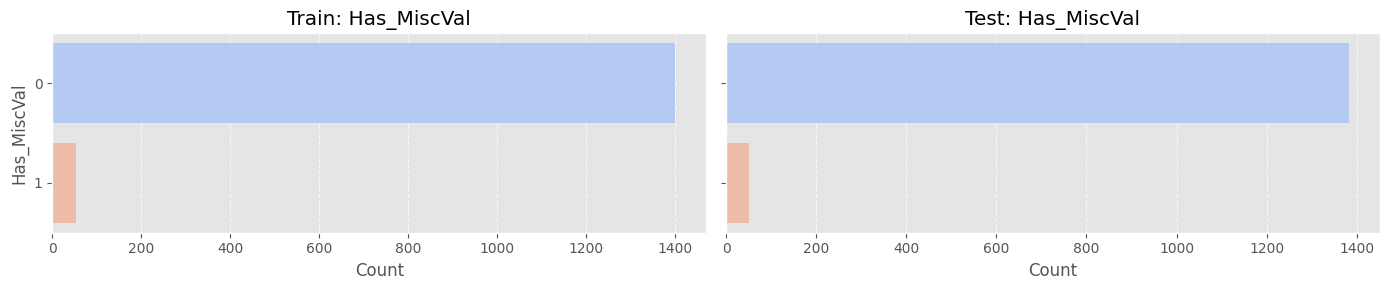

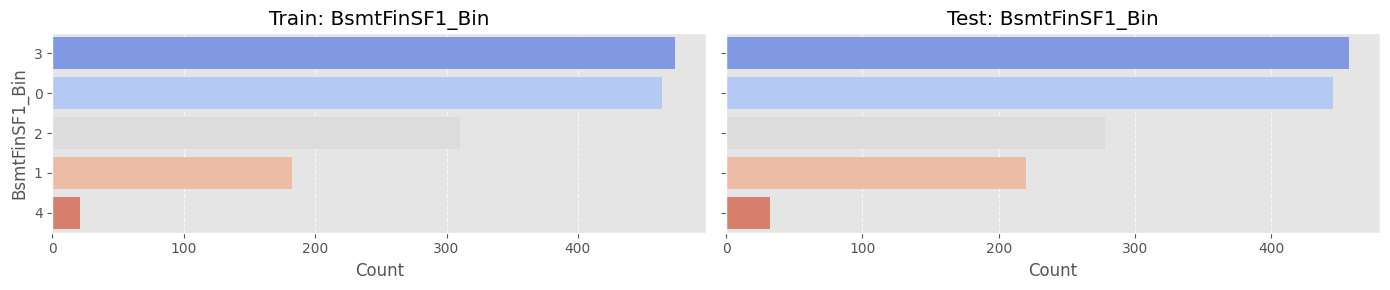

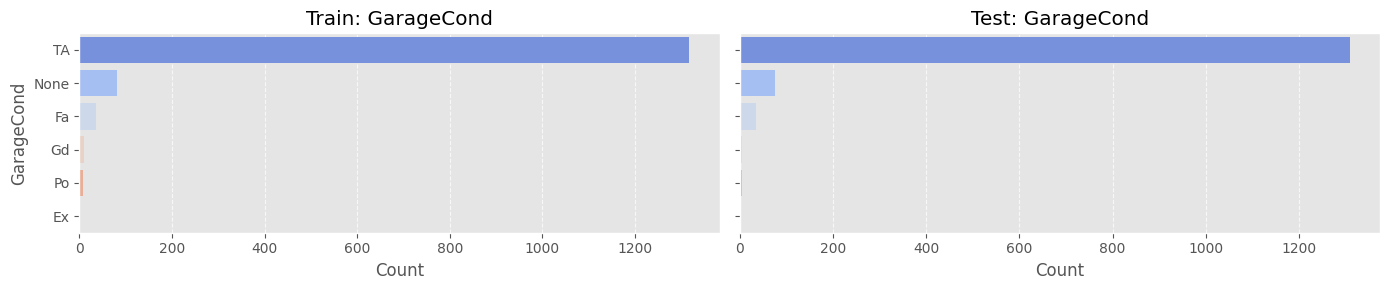

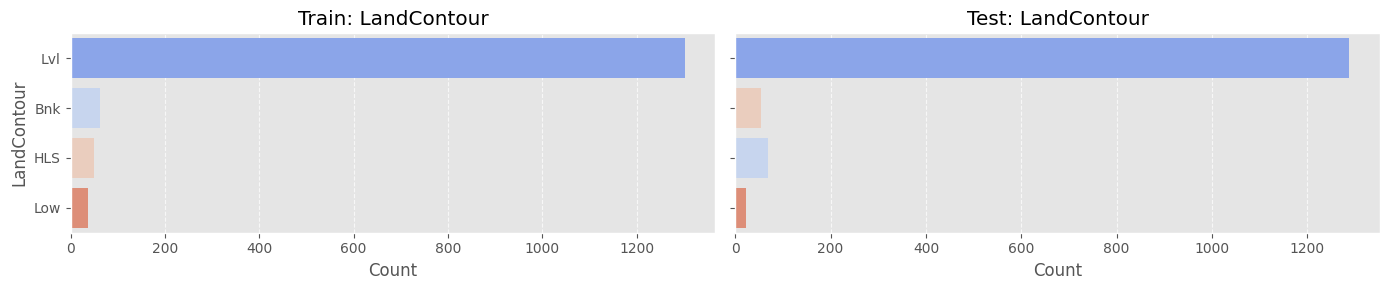

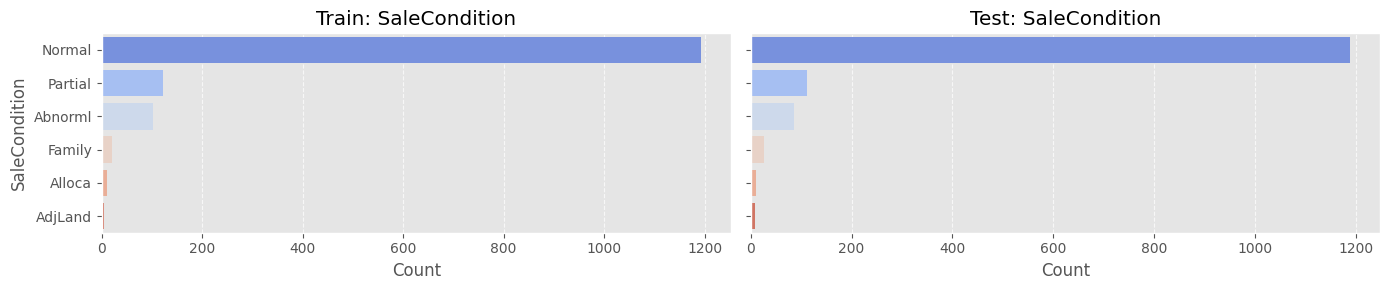

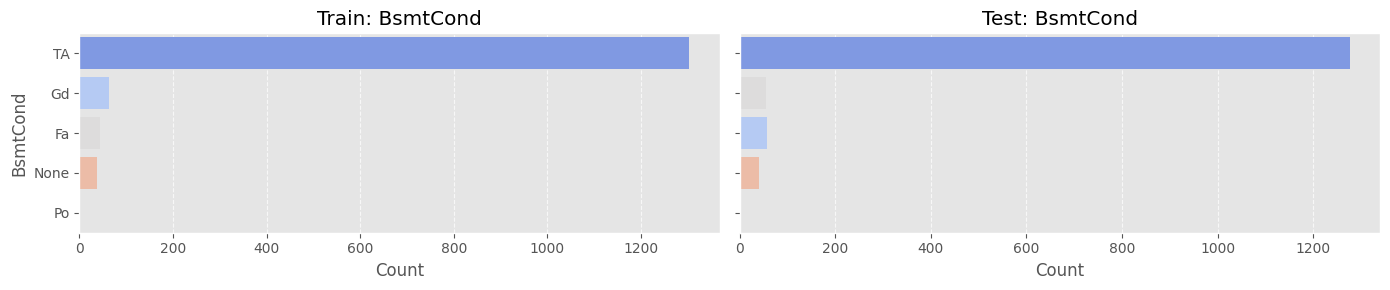

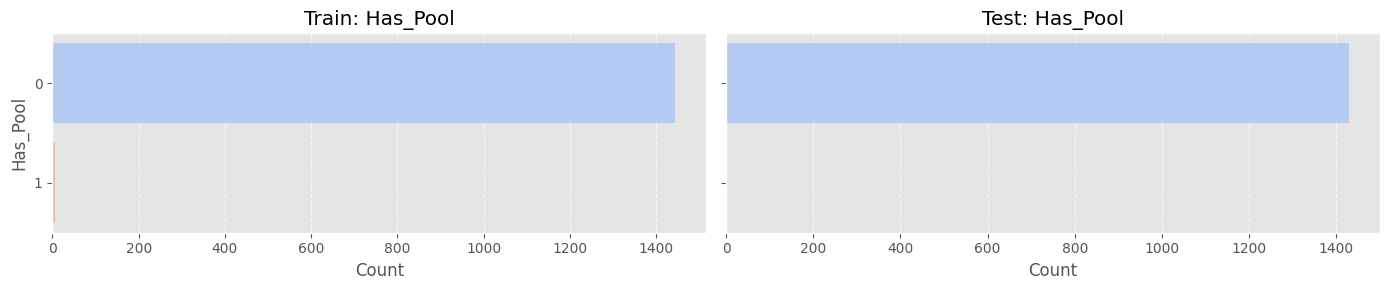

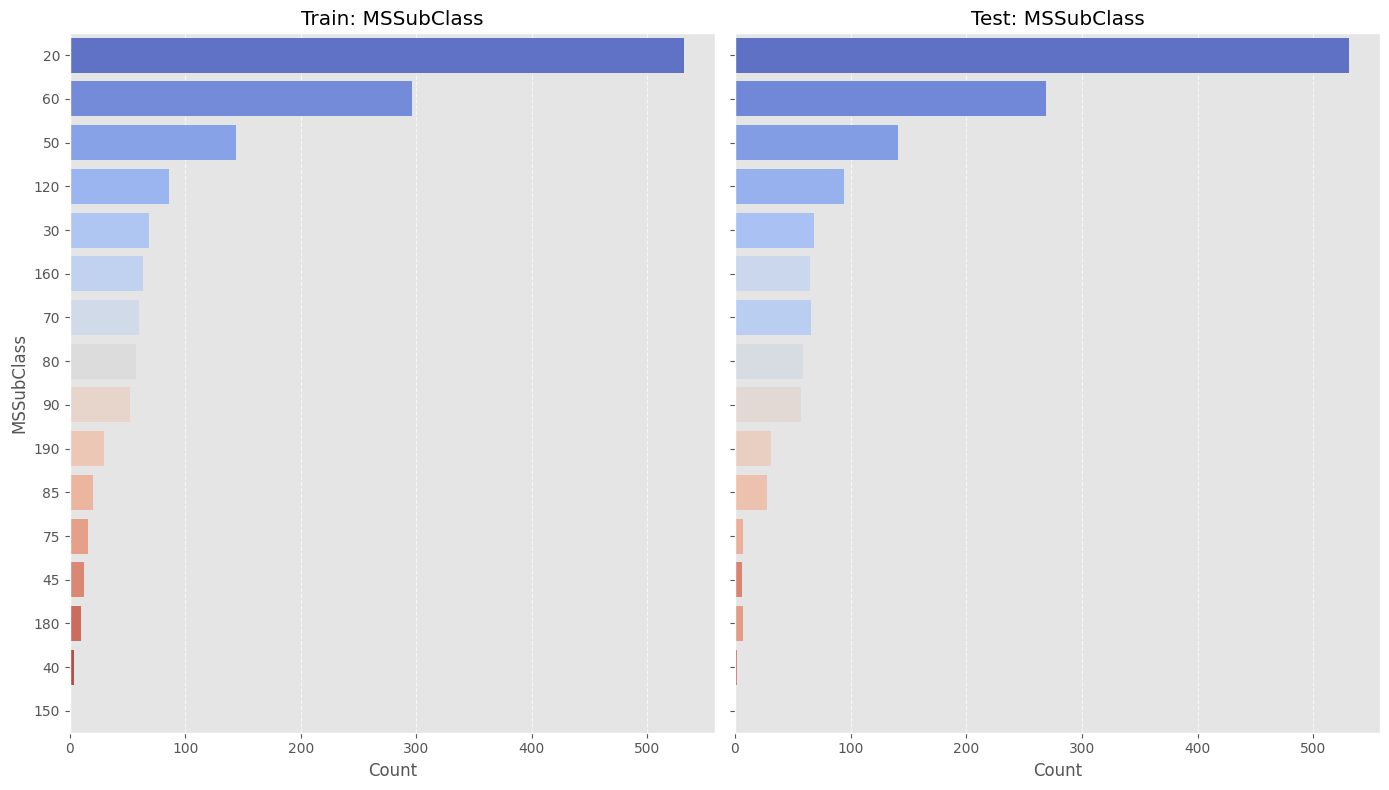

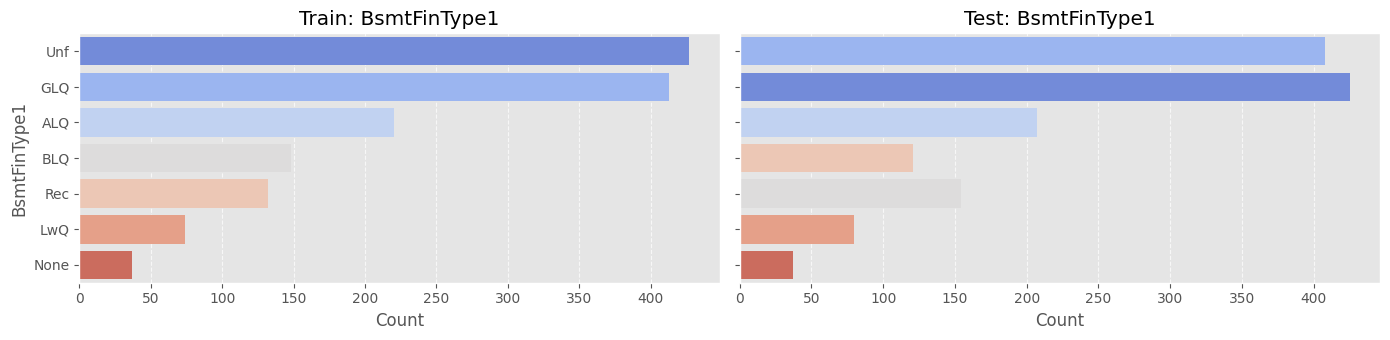

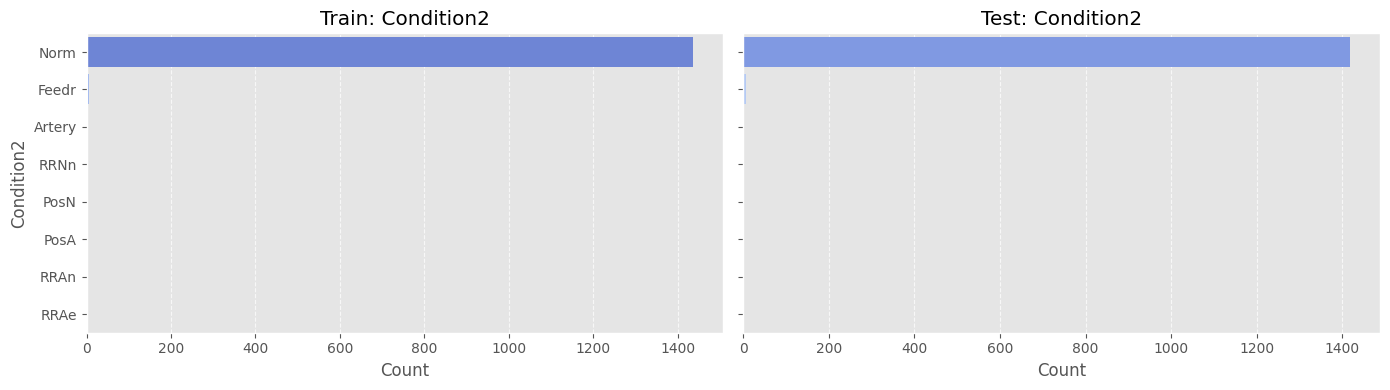

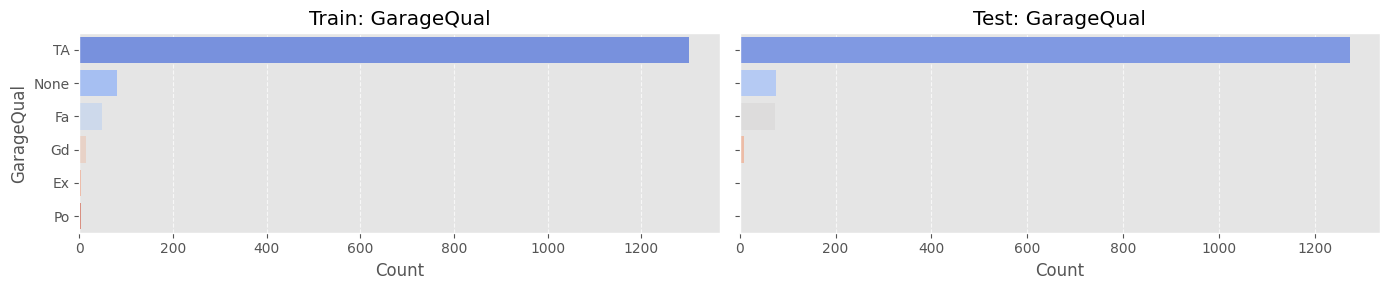

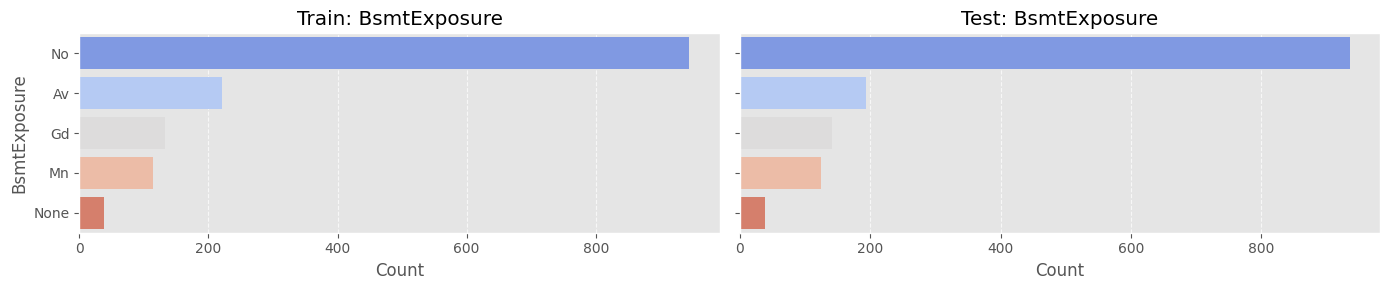

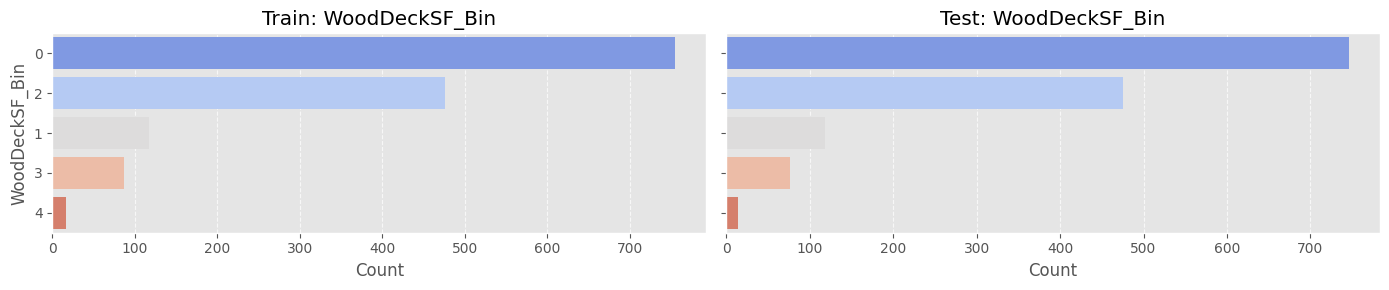

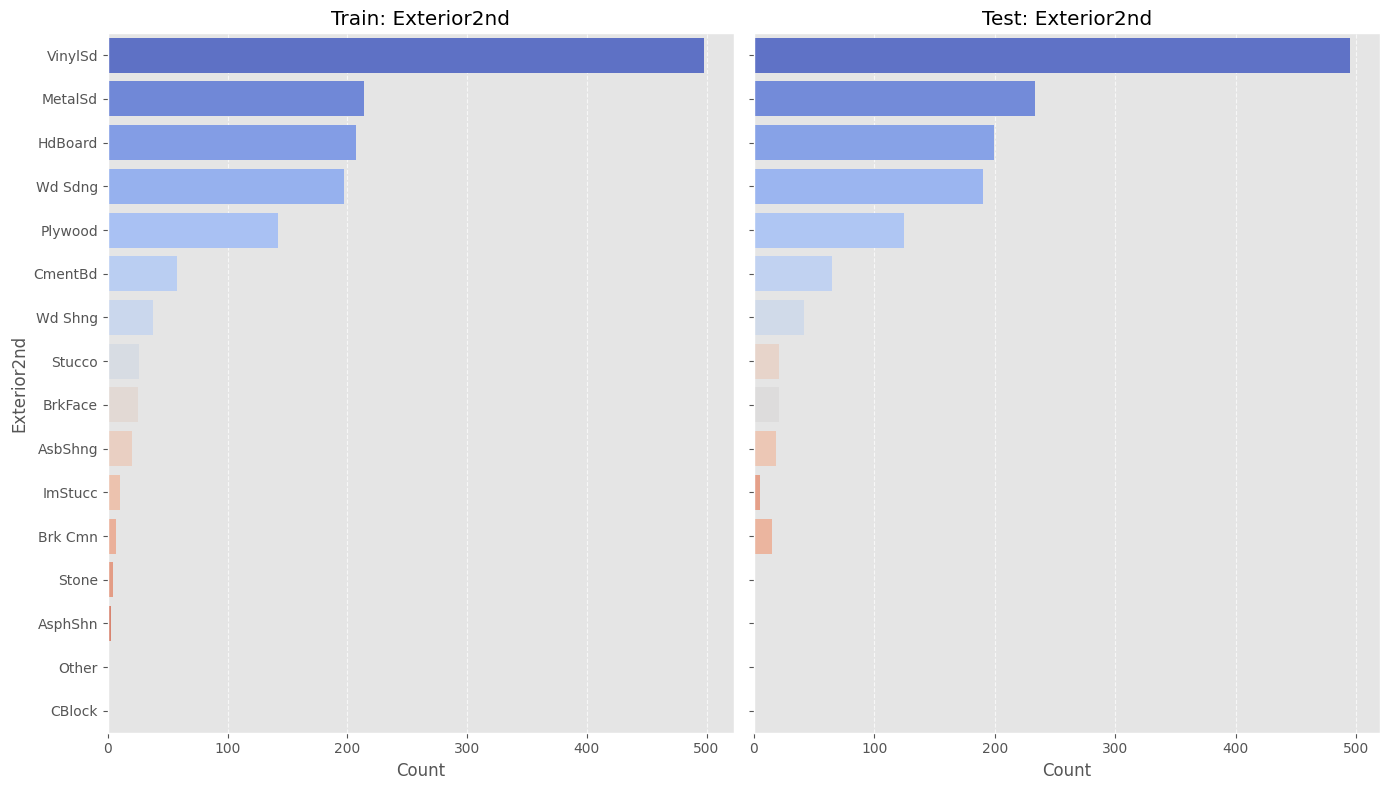

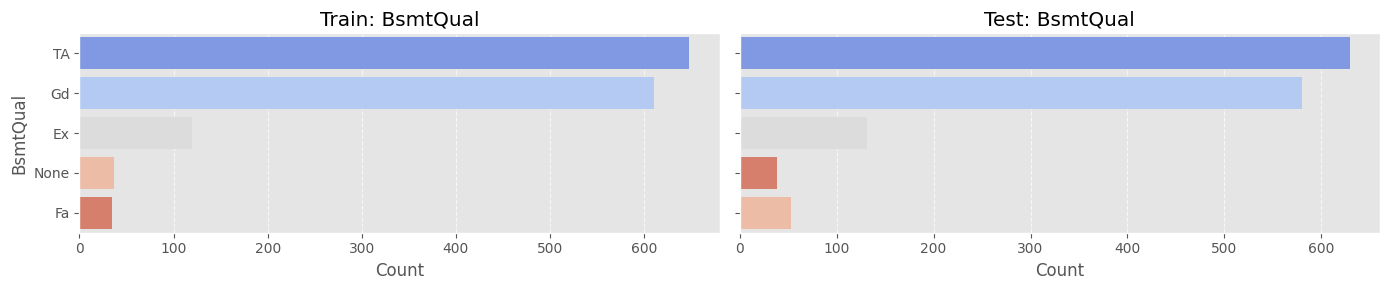

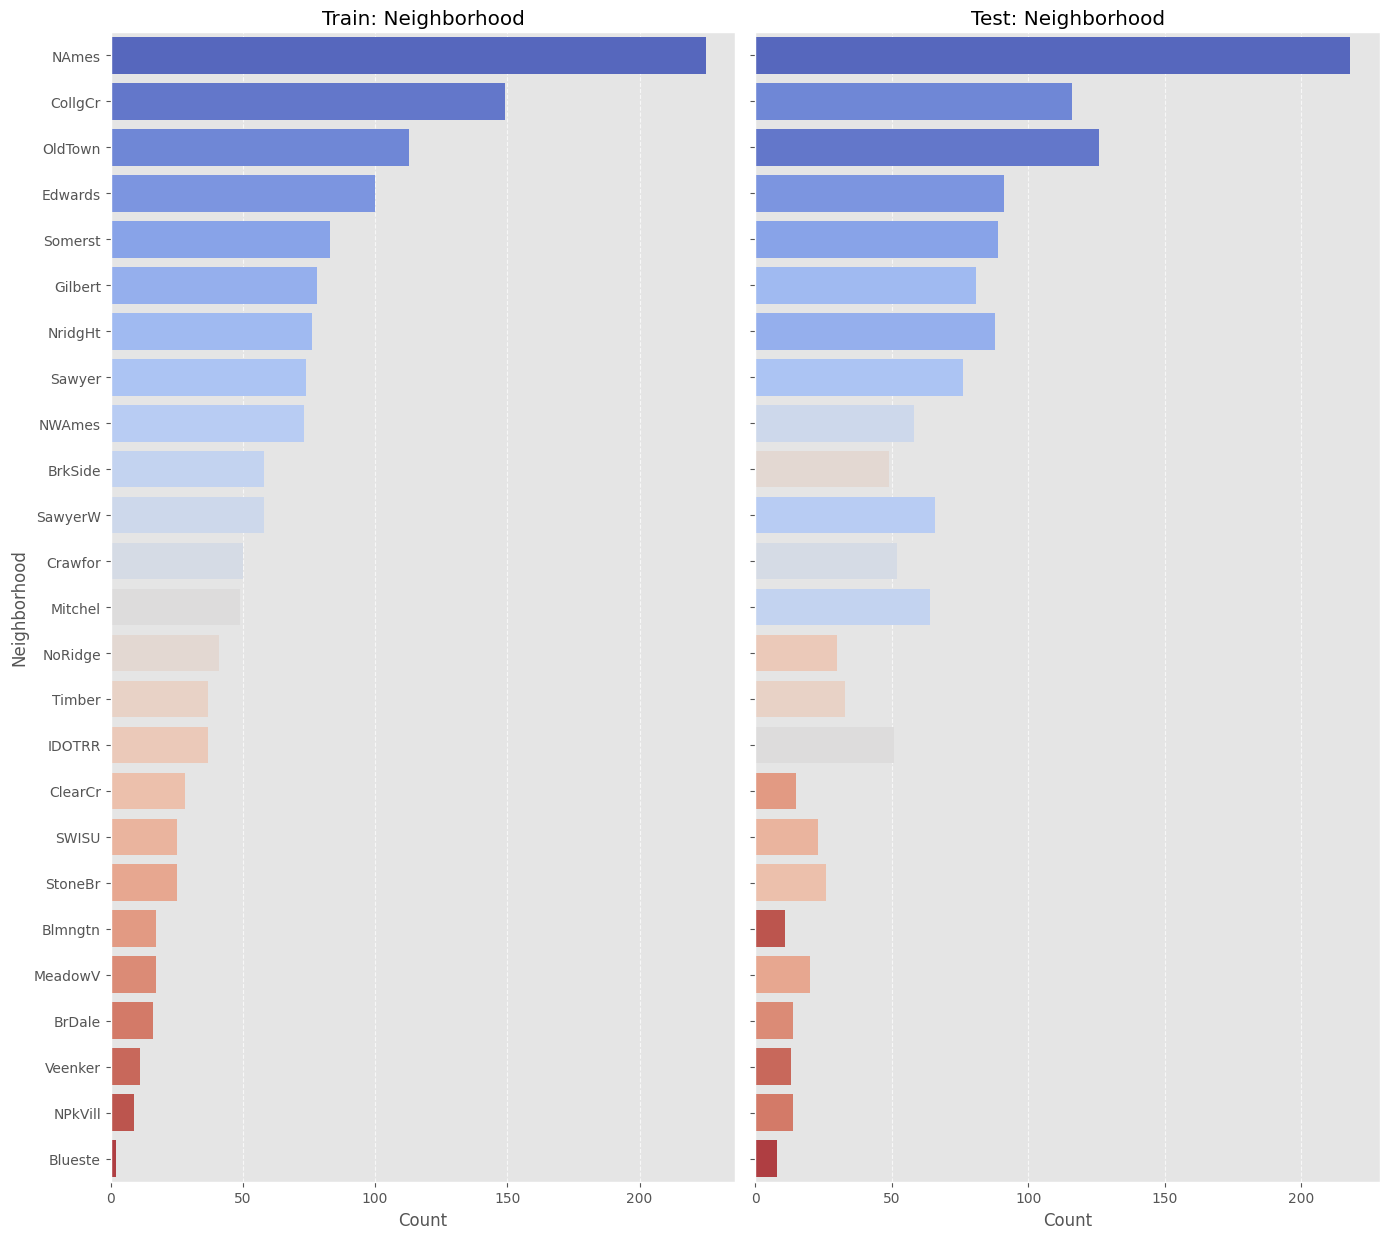

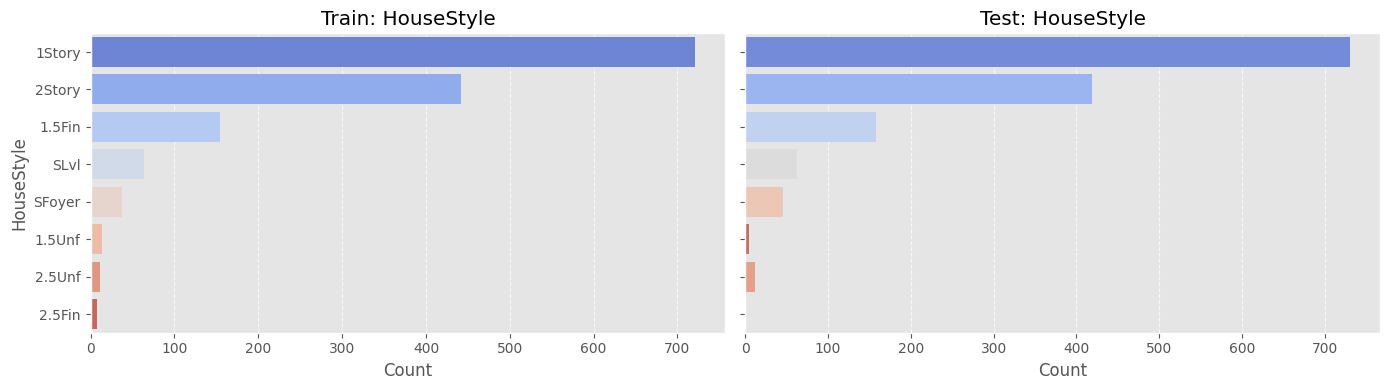

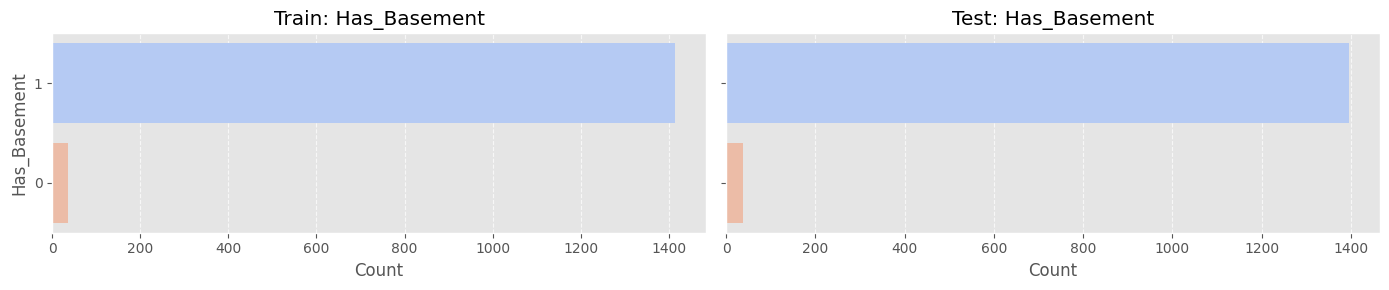

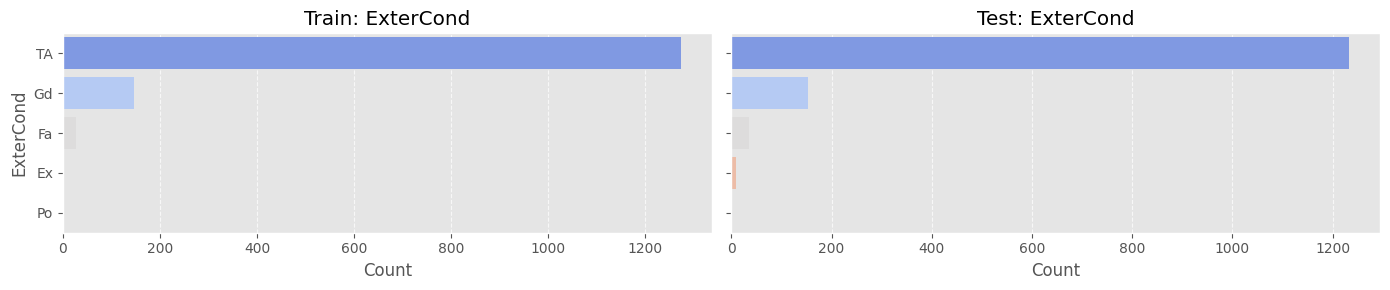

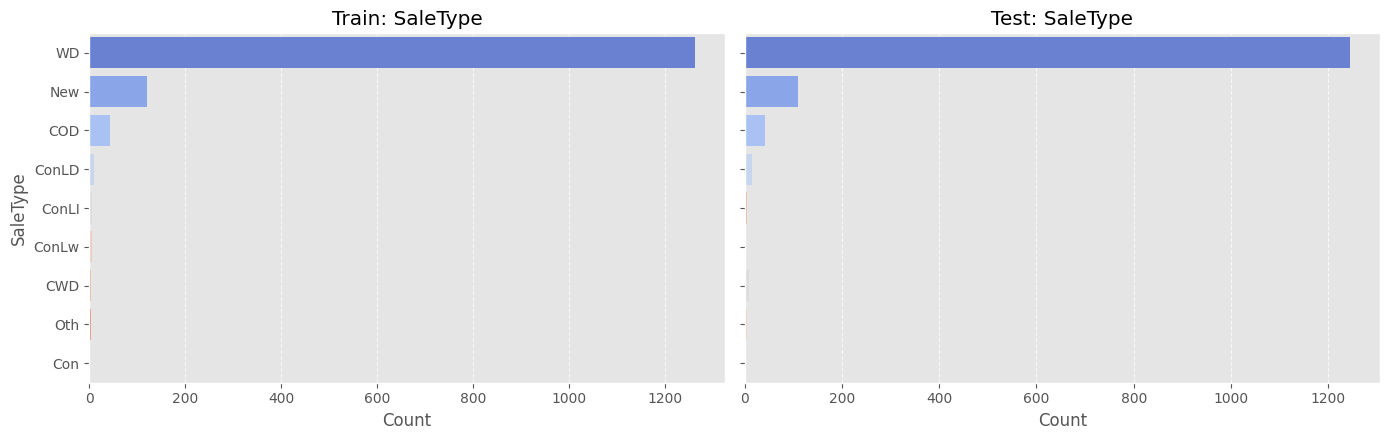

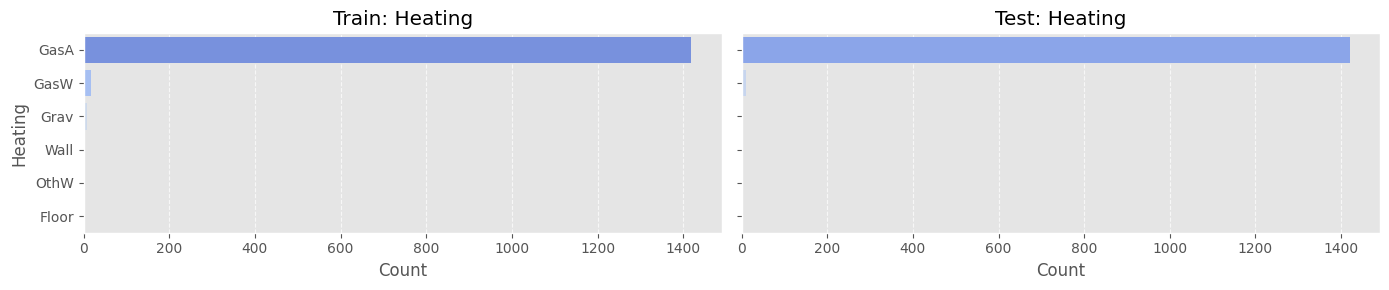

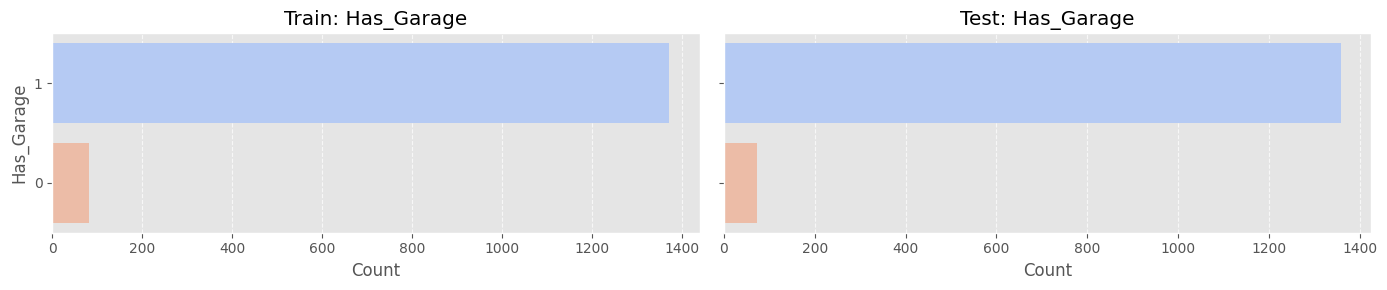

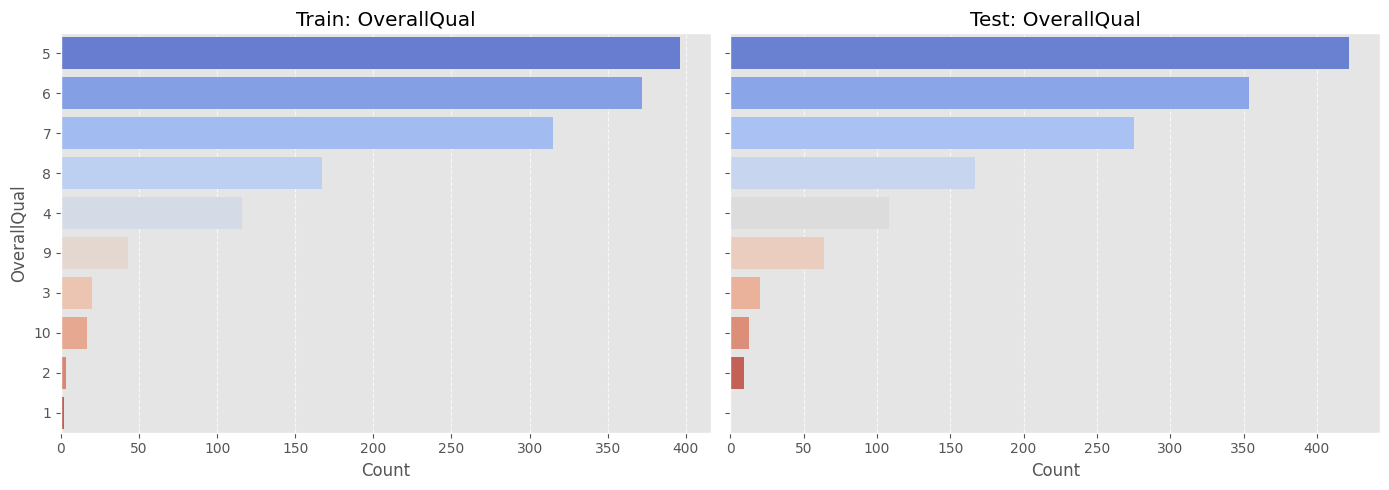

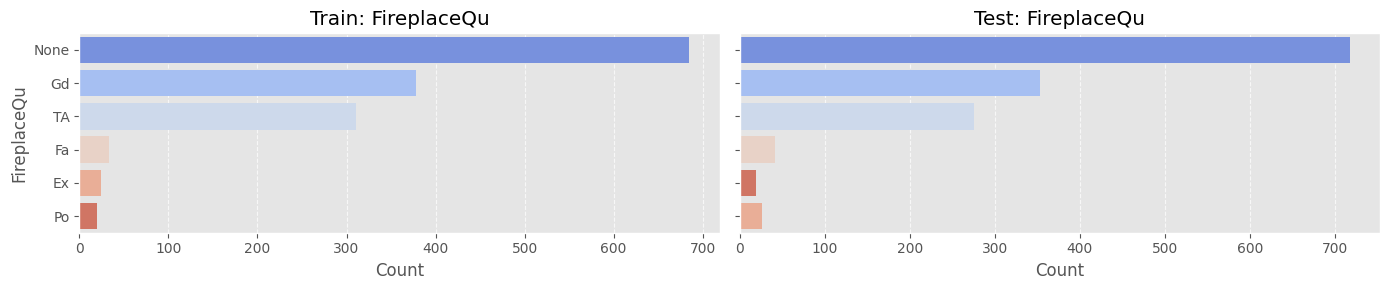

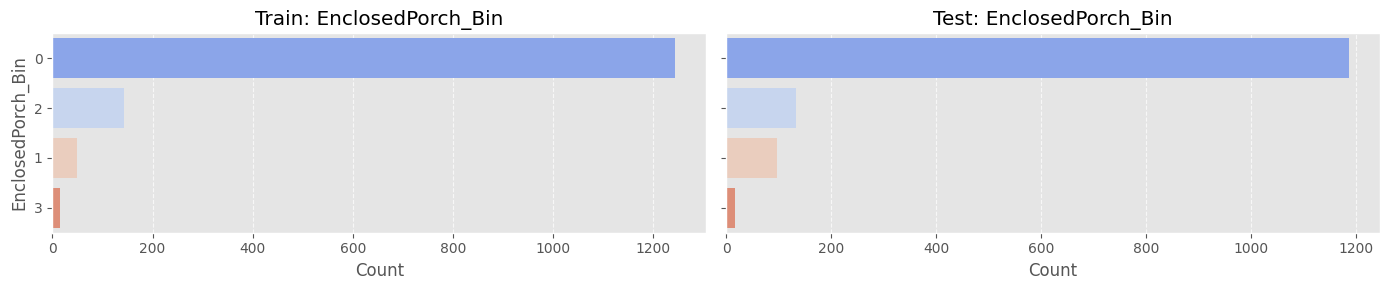

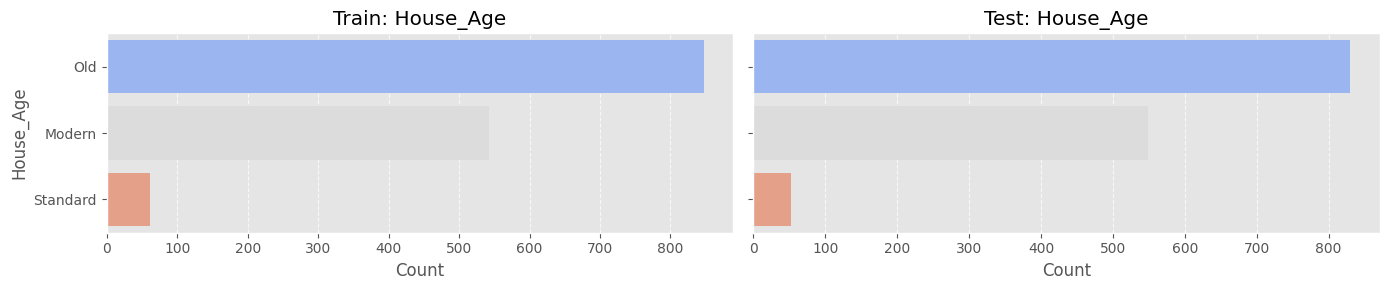

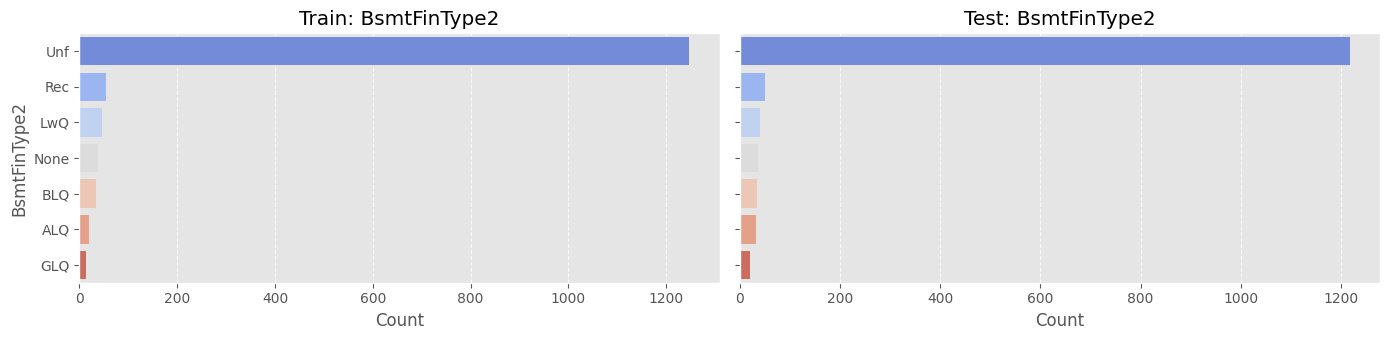

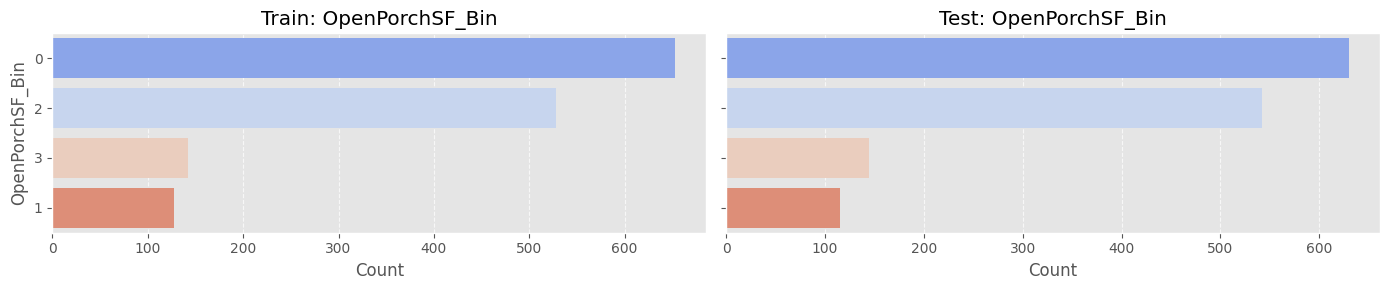

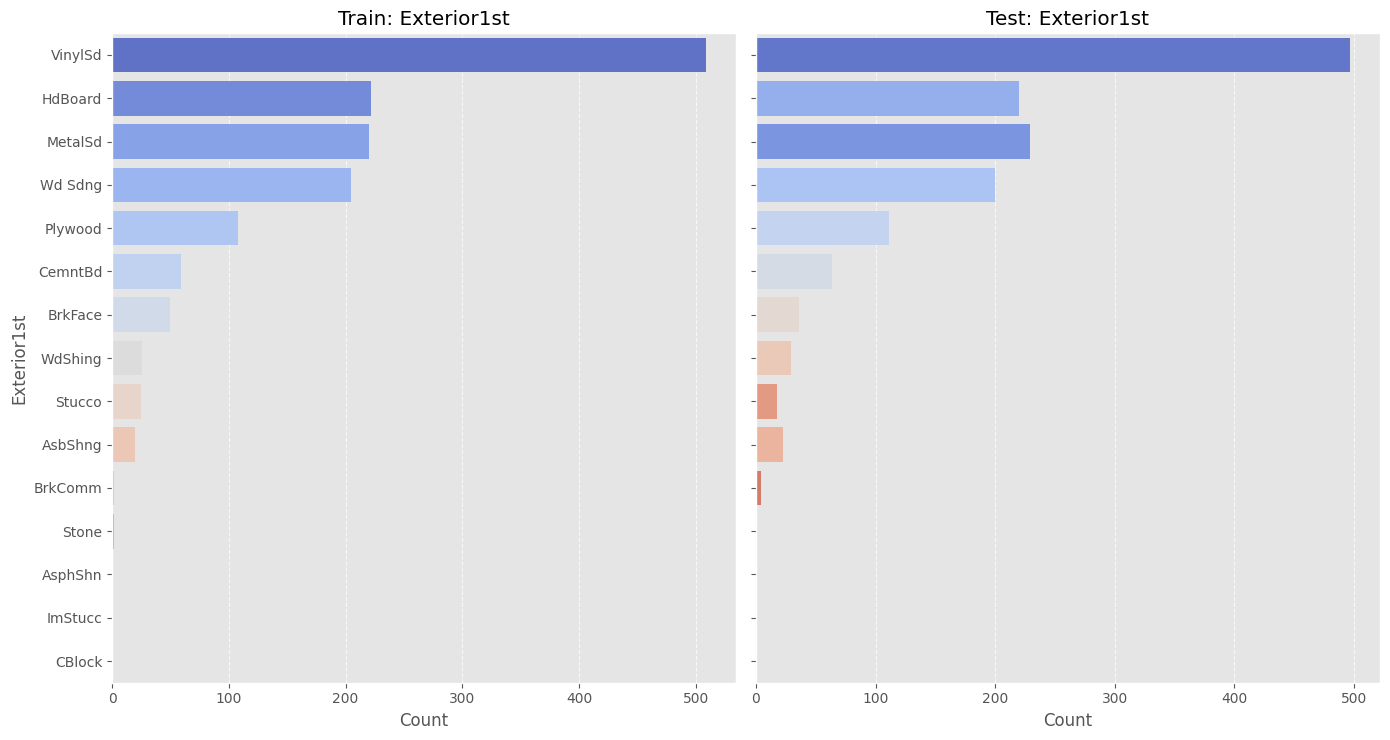

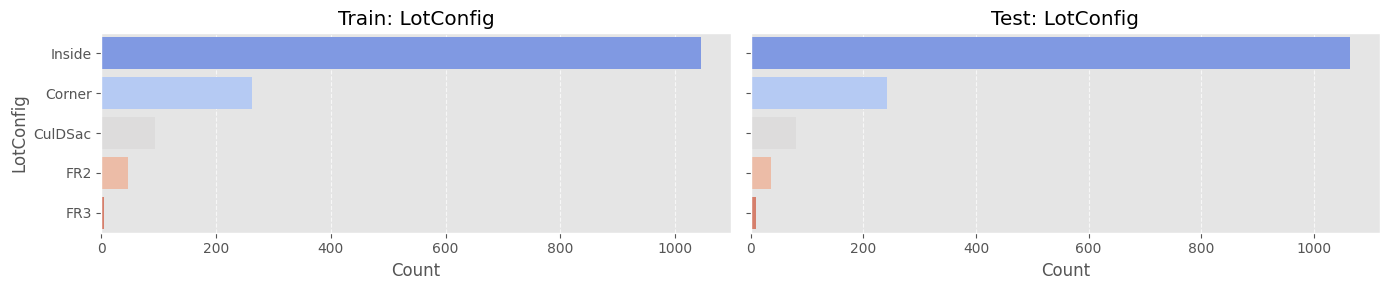

In [21]:
# Identify categorical features dynamically
binned_features = [col for col in train.columns if col.endswith("_Bin")]
has_features = [col for col in train.columns if col.startswith("Has_")]
new_categorical_features = ["House_Age"]

# Combine all categorical features and remove duplicates
all_categorical_features = list(set(categorical_features + ordinal_features + binned_features + has_features + new_categorical_features))

def plot_categorical_features(train_data, test_data, features):
    """
    Plots only horizontal bar charts for categorical, ordinal, binned (_Bin), and "Has_" features.
    Ensures all plots are forced to be horizontal.
    """
    for feature in features:
        if feature not in train_data.columns or feature not in test_data.columns:
            continue  # Skip missing features

        # Compute value counts and sort
        train_counts = train_data[feature].value_counts().reset_index().sort_values(by="count", ascending=False)
        test_counts = test_data[feature].value_counts().reset_index().sort_values(by="count", ascending=False)

        # Ensure category names are string type for consistent plotting
        train_counts[feature] = train_counts[feature].astype(str)
        test_counts[feature] = test_counts[feature].astype(str)

        # Set figure size dynamically
        num_categories = max(len(train_counts), len(test_counts))
        fig, axes = plt.subplots(1, 2, figsize=(14, max(3, 0.5 * num_categories)), sharey=True)

        # FORCE HORIZONTAL BARS
        sns.barplot(y=train_counts[feature], x=train_counts["count"], palette="coolwarm", ax=axes[0])
        sns.barplot(y=test_counts[feature], x=test_counts["count"], palette="coolwarm", ax=axes[1])

        # Titles and labels
        for ax, title in zip(axes, ["Train", "Test"]):
            ax.set_xlabel("Count")
            ax.set_ylabel(feature)
            ax.set_title(f"{title}: {feature}")
            ax.grid(axis="x", linestyle="--", alpha=0.7)

        plt.tight_layout()
        plt.show()

# Call the function
plot_categorical_features(train, test, all_categorical_features)


### **Categorical Feature Analysis & Insights**

**1. LandSlope**
- The majority of properties (~95%) have a gentle slope (`Gtl`).
- Very few properties have a steep slope (`Sev`), and even fewer in the test set.

**2. HouseStyle**
- `1Story` and `2Story` are dominant (~80% of homes).
- Rare styles such as `2.5Fin`, `2.5Unf`, and `1.5Unf` have very few occurrences, making them difficult for predictive modeling.

**3. EnclosedPorch_Bin**
- Most houses (~86%) have no enclosed porch (`Bin = 0`).
- Higher bins (`Bin = 3`) account for just ~1%, suggesting that enclosed porches are relatively rare.

**4. Functional**
- Over 90% of homes are classified as `Typ` (Typical Functionality).
- Only one home in the train set is categorized as `Sev` (Severely damaged), making it an extreme outlier.

**5. BsmtUnfSF_Bin**
- This feature is well distributed across bins, with the highest concentration in `Bin = 1`.

**6. Heating**
- `GasA` (Gas heating) is overwhelmingly dominant (~97% of all homes).
- Other types (`GasW`, `Grav`, `Wall`, `Floor`, `OthW`) appear in tiny proportions and may not significantly impact predictions.

**7. RoofStyle**
- Most homes have `Gable` (~75%) or `Hip` (~20%) roofs.
- Other styles (`Flat`, `Gambrel`, `Mansard`, `Shed`) are rare, possibly making them less influential features.

**8. 2ndFlrSF_Bin**
- Over half of the houses (~57%) have no second floor (`Bin = 0`).
- Houses with significant second-floor space (`Bin = 4`) are relatively rare.

**9. LotShape**
- `Reg` (Regular) shape dominates (~70%).
- Irregular shapes (`IR1`, `IR2`, `IR3`) are relatively less common but might indicate larger or uniquely shaped lots.

**10. Exterior1st**
- Vinyl Siding (`VinylSd`), Metal (`MetalSd`), Hardboard (`HdBoard`), and Wood (`Wd Sdng`) are the most frequent materials.
- `Stone`, `CBlock`, and `ImStucc` are extremely rare, making them potential noise factors in modeling.

**11. BsmtFinSF1_Bin**
- The data is clustered into a few key bins, with `Bin = 3` being the most common.
- There is a balance across multiple bins, making it a potentially useful feature.

**12. Has_MiscVal**
- Most homes (~96%) have no miscellaneous value (`0`).
- A small percentage (`4%`) have a nonzero value, indicating extra costs for additions such as sheds or minor upgrades.

**13. GarageQual**
- Over 90% of garages are rated as `TA` (Typical/Average).
- Very few garages are rated `Po` (Poor), `Ex` (Excellent), or `Gd` (Good), making these categories less useful.

**14. ExterCond**
- `TA` (Typical) is the dominant category (~87%).
- Extreme cases (`Ex` - Excellent, `Po` - Poor) are rare.

**15. Neighborhood**
- `NAmes` (North Ames), `OldTown`, and `CollgCr` (College Creek) are the most common neighborhoods.
- Some neighborhoods such as `Blueste` and `NPkVill` are underrepresented, making them less reliable for predictions.

**16. MasVnrArea_Bin**
- About 60% of houses fall into `Bin=0` (No Masonry).
- Masonry veneer area does vary, with moderate counts in `Bin = 2, 3, 4`, but the highest bins are less common.

**17. OpenPorchSF_Bin**
- The distribution across bins is fairly balanced, suggesting it might be useful in predictive modeling.

**18. PoolQC**
- 99% of houses have `None` (No pool).
- Only a handful of homes have pools (`Ex`, `Gd`, `Fa` categories), making this feature unlikely to be useful unless aggregated into `Has_Pool`.

**19. BsmtFinSF2_Bin**
- Over 85% of homes fall into `Bin = 0`, indicating that most homes do not have a second finished basement.
- Higher bins are relatively rare.

**20. SaleType**
- `WD` (Warranty Deed) is the dominant sale type (~87%).
- `New` homes account for ~10%, while other sale types are much less frequent.

**21. SaleCondition**
- `Normal` sales account for ~80%.
- `Partial` (new construction) is significant (~10%).
- `Abnorml` (Abnormal Sale) is present in ~6% of cases.

**22. BsmtQual**
- `TA` and `Gd` dominate (~90%), indicating most basements have typical or good quality.
- `Ex` (Excellent) is less common but may indicate premium homes.

**23. GarageCond**
- Follows a similar trend to `GarageQual`, with `TA` being the dominant category.

**24. Foundation**
- Poured Concrete (`PConc`) and Cinder Block (`CBlock`) are the most common (~85%).
- `Wood` and `Stone` foundations are rare.

**25. Electrical**
- `SBrkr` (Standard Breaker) dominates (~95%).
- Other types (`FuseA`, `FuseF`, `Mix`) appear in very small numbers.

**26. OverallQual**
- Houses are most commonly rated `5`, `6`, or `7`, which suggests the majority have average to above-average quality.
- Very few homes have extreme quality ratings (`1`, `2`, `10`).

**27. BldgType**
- `1Fam` (Single-Family Home) dominates (~85%).
- Townhouses (`Twnhs`, `TwnhsE`) and Duplexes (`2fmCon`) are significantly less frequent.

**28. Exterior2nd**
- Follows a similar pattern as `Exterior1st`, with Vinyl, Metal, and Wood being dominant.

**29. Condition1 / Condition2**
- `Norm` (Normal) is overwhelmingly dominant (~85%).
- Unusual conditions such as `Artery`, `Feedr`, `PosN`, and `RRAe` appear in small numbers.

**30. OverallCond**
- Most homes fall into `5`, `6`, or `7`.
- Extreme conditions (`1`, `2`, `9`) are rare.

**31. PavedDrive**
- Mostly `Y` (Paved Driveway).

**32. LotArea_Bin**
- The bin distribution is well spread, suggesting it may be useful in predicting price.

**33. Fence**
- `None` is dominant (~80%), meaning most homes do not have a fenced yard.
- The few cases of `MnPrv`, `GdPrv`, and `GdWo` indicate partial or good wooden privacy fences.

**34. Has_Garage**
- Over 95% of homes have a garage.

**35. Has_Basement**
- Almost all homes (~98%) have a basement, making it redundant unless combined with other basement-related features.

**36. Has_Pool**
- Only a few homes (~0.5%) have pools, making it a highly skewed feature.

**Key Takeaways**
- **Dominant Categories**: Many categorical variables have a dominant category that accounts for over 90% of the data (e.g., `GasA` for Heating, `SBrkr` for Electrical, `PConc` for Foundation). These features might not be very useful unless combined with other information.
- **Highly Skewed Features**: Features like `PoolQC`, `MiscVal`, `GarageCond`, and `BsmtFinSF2` have very few occurrences outside their dominant category, meaning they might not contribute much predictive power.
- **Well-Distributed Features**: Variables like `Neighborhood`, `OverallQual`, and `LotArea_Bin` are well-distributed, making them strong candidates for feature importance.
- **Redundant Features**: Some binary features (`Has_Basement`, `Has_Garage`) may not add much value since their parent features already indicate the same information.

## Correlation analysis

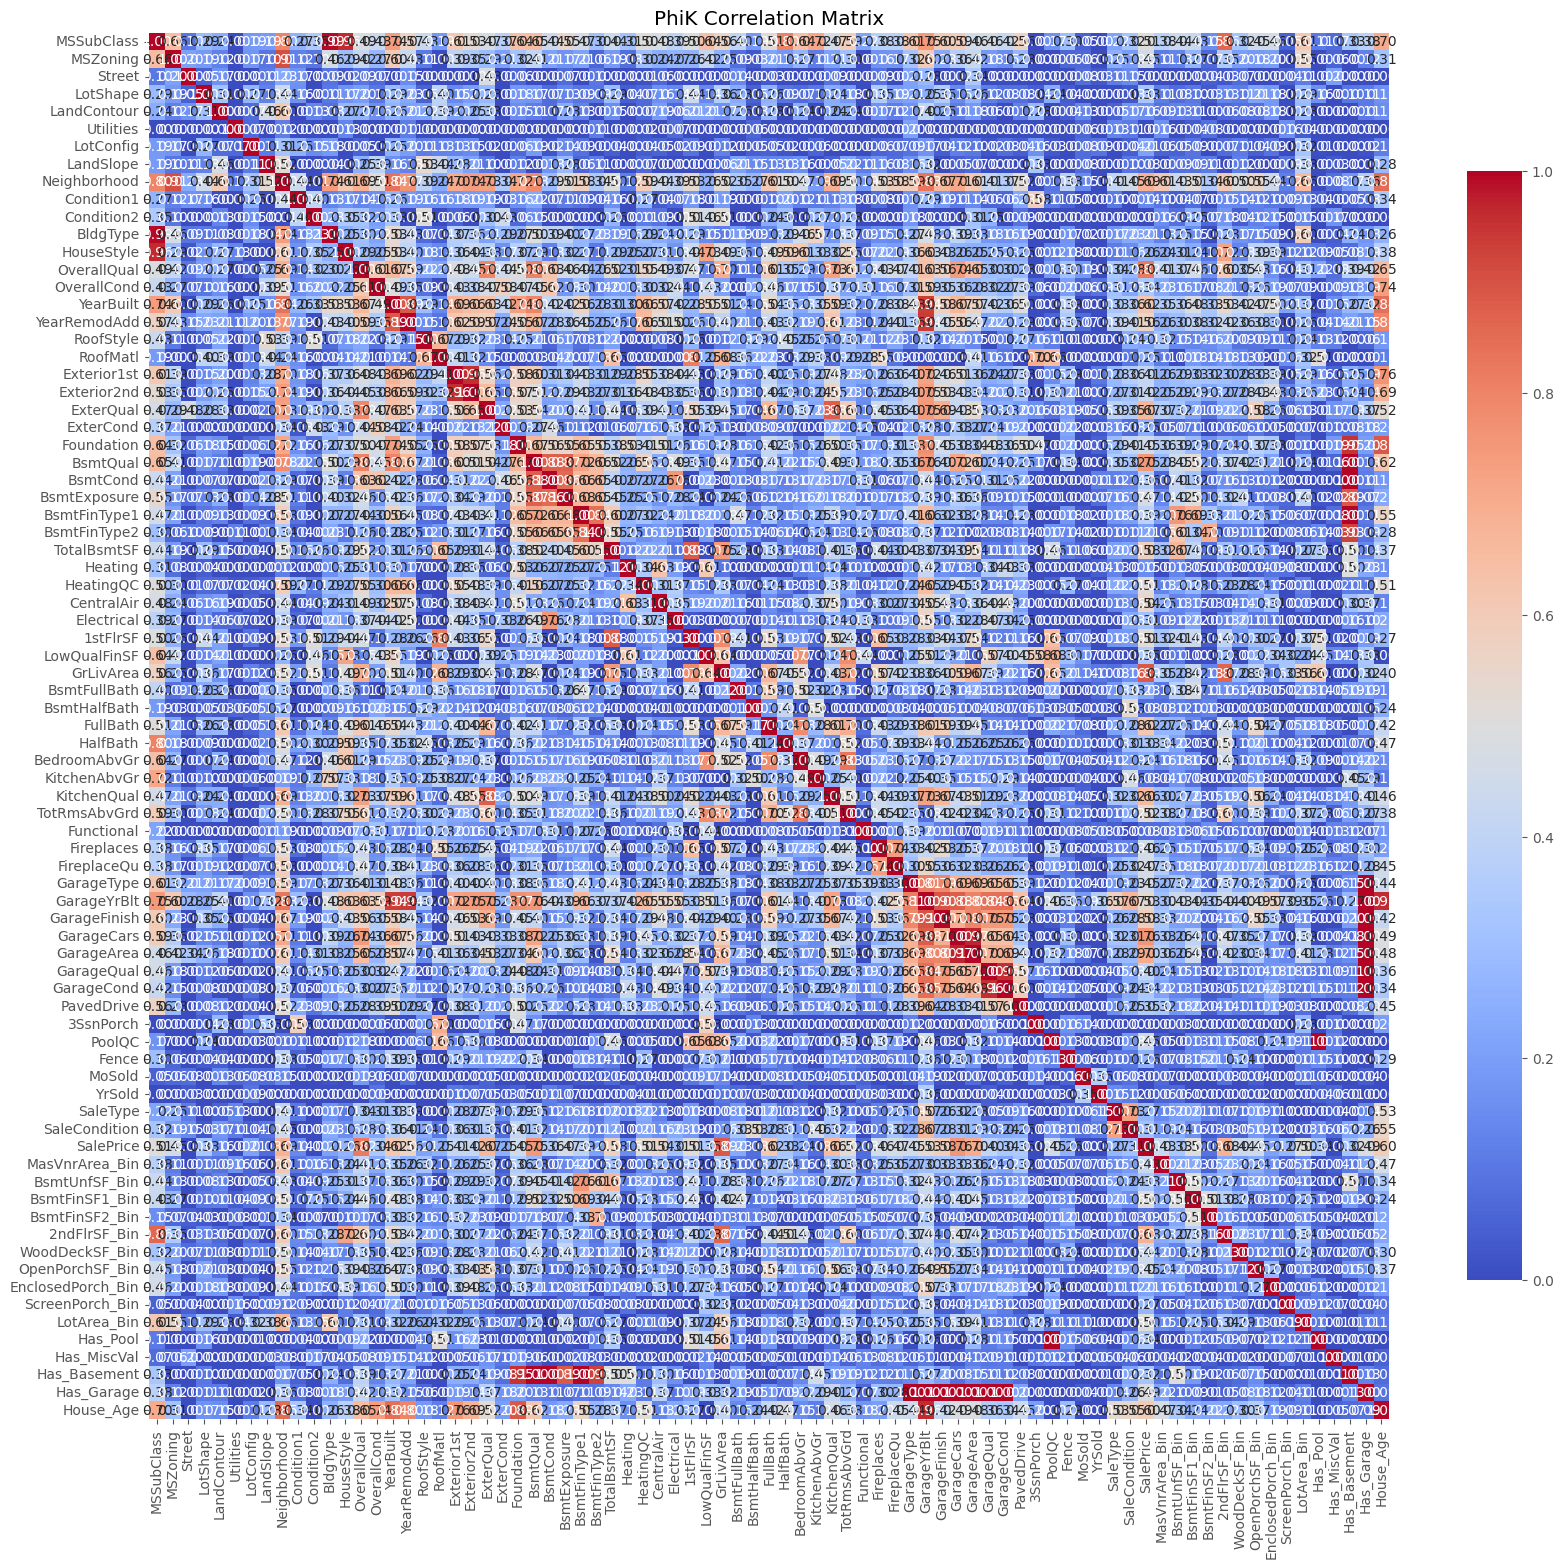

Highly Correlated Features (PhiK > 0.9):
         feature_1     feature_2  phi_k_value
11      MSSubClass      BldgType     0.994468
12      MSSubClass    HouseStyle     0.962961
87        MSZoning  Neighborhood     0.908111
633   Neighborhood      MSZoning     0.908111
869       BldgType    MSSubClass     0.994468
948     HouseStyle    MSSubClass     0.962961
1234     YearBuilt   GarageYrBlt     0.936959
1313  YearRemodAdd   GarageYrBlt     0.937575
1521   Exterior1st   Exterior2nd     0.960024
1599   Exterior2nd   Exterior1st     0.960024
1893    Foundation  Has_Basement     0.950469
1972      BsmtQual  Has_Basement     1.000000
2051      BsmtCond  Has_Basement     1.000000
2209  BsmtFinType1  Has_Basement     1.000000
2288  BsmtFinType2  Has_Basement     0.928622
3869    GarageType    Has_Garage     1.000000
3886   GarageYrBlt     YearBuilt     0.936959
3887   GarageYrBlt  YearRemodAdd     0.937575
3948   GarageYrBlt    Has_Garage     1.000000
3949   GarageYrBlt     House_Age     0.

MSSubClass  MSZoning    Street  LotShape  LandContour  \
MSSubClass           1.000000  0.655542  0.100650  0.288979     0.244465   
MSZoning             0.655542  1.000000  0.204178  0.187191     0.124404   
Street               0.100650  0.204178  1.000000  0.050749     0.171568   
LotShape             0.288979  0.187191  0.050749  1.000000     0.312368   
LandContour          0.244465  0.124404  0.171568  0.312368     1.000000   
Utilities            0.000000  0.000000  0.000000  0.000000     0.000000   
LotConfig            0.185714  0.172070  0.000000  0.266943     0.074258   
LandSlope            0.189465  0.095441  0.106452  0.125784     0.461823   
Neighborhood         0.797227  0.908111  0.232717  0.441811     0.602522   
Condition1           0.265200  0.122579  0.165412  0.163088     0.000000   
Condition2           0.349857  0.095806  0.000000  0.000000     0.130761   
BldgType             0.994468  0.463884  0.091895  0.105420     0.084349   
HouseStyle           0.962961  0.294897  0.024893  0.165189     0.274456   
OverallQual          0.485781  0.421732  0.094588  0.195914     0.265352   
OverallCond          0.430068  0.273873  0.068059  0.099382     0.156869   
YearBuilt            0.740340  0.603835  0.000000  0.287982     0.263551   
YearRemodAdd         0.570229  0.433583  0.150536  0.228924     0.209644   
RoofStyle            0.431716  0.106835  0.000000  0.053921     0.215898   
RoofMatl             0.186205  0.000000  0.000000  0.396443     0.386300   
Exterior1st          0.608619  0.390834  0.000000  0.145639     0.203471   
Exterior2nd          0.527893  0.347197  0.000000  0.197909     0.254477   
ExterQual            0.470226  0.286446  0.475247  0.282458     0.329786   
ExterCond            0.372489  0.206569  0.000000  0.000000     0.000000   
Foundation           0.637314  0.319168  0.060782  0.182073     0.154896   
BsmtQual             0.648773  0.409837  0.000000  0.174263     0.113405   
BsmtCond             0.435411  0.207248  0.000000  0.073230     0.074345   
BsmtExposure         0.545302  0.170011  0.071449  0.130066     0.234548   
BsmtFinType1         0.468105  0.207221  0.000000  0.094804     0.126316   
BsmtFinType2         0.304386  0.058948  0.097695  0.094636     0.000000   
TotalBsmtSF          0.440369  0.186024  0.000000  0.285713     0.153634   
Heating              0.310571  0.080416  0.000000  0.039153     0.000000   
HeatingQC            0.504387  0.298820  0.013873  0.067529     0.065648   
CentralAir           0.476270  0.242599  0.063235  0.163676     0.192996   
Electrical           0.389530  0.267722  0.000000  0.137646     0.062936   
1stFlrSF             0.497789  0.261019  0.000000  0.436933     0.212192   
LowQualFinSF         0.637506  0.419018  0.000000  0.141360     0.210469   
GrLivArea            0.564894  0.248929  0.000000  0.359695     0.165974   
BsmtFullBath         0.404408  0.085496  0.137712  0.234637     0.262476   
BsmtHalfBath         0.185864  0.025508  0.000000  0.047783     0.028006   
FullBath             0.511911  0.213051  0.031969  0.260074     0.276491   
HalfBath             0.803920  0.182212  0.000000  0.091622     0.000000   
BedroomAbvGr         0.640061  0.266452  0.000000  0.070369     0.242748   
KitchenAbvGr         0.717121  0.112313  0.000000  0.104383     0.000000   
KitchenQual          0.467847  0.209083  0.092834  0.237695     0.241572   
TotRmsAbvGrd         0.593324  0.304201  0.000000  0.181690     0.243109   
Functional           0.216632  0.000000  0.000000  0.000000     0.000000   
Fireplaces           0.378084  0.164620  0.090869  0.346557     0.168496   
FireplaceQu          0.384801  0.173625  0.000000  0.188746     0.116804   
GarageType           0.610722  0.320138  0.208754  0.209570     0.167522   
GarageYrBlt          0.749974  0.602836  0.278121  0.245287     0.404774   
GarageFinish         0.597700  0.233883  0.000000  0.351840     0.253462   
GarageCars           0.594179  0.364813  0.021987  0.147924     0.1

In [26]:
# Select all columns except the 'ID' column for correlation analysis
# Assuming 'ID' is the name of the column with the identifier
features_for_phik = [col for col in train.columns if col.lower() != 'id']
continuous_columns = ['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea', 'MoSold', 'YrSold', 'SalePrice']

# Compute PhiK correlation matrix for train dataset
phik_corr = train[features_for_phik].phik_matrix(interval_cols=continuous_columns)

# Visualize the PhiK correlation matrix
plt.figure(figsize=(20, 18))
sns.heatmap(phik_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": 0.8})
plt.title("PhiK Correlation Matrix")
plt.show()

# Filter correlations greater than 0.9, excluding self-correlations
high_corr = phik_corr.stack().reset_index()
high_corr.columns = ['feature_1', 'feature_2', 'phi_k_value']
high_corr = high_corr[(high_corr['phi_k_value'] > 0.9) & (high_corr['feature_1'] != high_corr['feature_2'])]

# Display highly correlated feature pairs
print("Highly Correlated Features (PhiK > 0.9):")
print(high_corr)

pd.options.display.max_rows = 9999
display(phik_corr)
